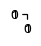

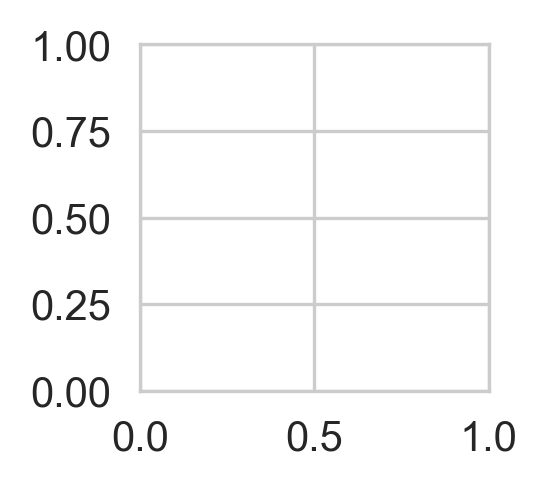

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.subplots(1,1,figsize=(1e-5, 1e-5))
mpl.rcParams['figure.dpi'] = 300
sns.set_style('whitegrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
import torch.nn.functional as F
import glob
# Here you import other functions and classes
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side, add_median_labels, get_palette
from src.data_processing import encode_batch, AA_KEYS, BL62_VALUES, BL62FREQ_VALUES, BL50, BL50_VALUES
from src.models import NNAlignEFSinglePass, NNAlignEFTwoStage
from src.datasets import NNAlignDataset
from sklearn.metrics import roc_auc_score, roc_curve
from scipy.stats import binomtest
plt.subplots(1,1,figsize=(1.5,1.5))
sns.set_palette('tab10', 6)

In [2]:
train_1 = pd.read_csv('../data/copy_rsync/250130_MHCI_structure_train_900k_fixed_partitions.csv')
test_1 = pd.read_csv('../data/copy_rsync/250213_MHCI_structure_test_79305_REFIXED_OVERLAP.csv')
train_2 = pd.read_csv('../data/copy_rsync/HLA_DR_subsample_all_partitions_922k.csv')
test_2 = pd.read_csv('../data/copy_rsync/HLA_DR_500K_unseen_sequence_test_set.csv')

# features analysis // summaries

In [3]:
def get_mean_feat(x):
    return np.mean([float(z) for z in x.split(',')])
fcols = ['rsa', 'disorder', 'pq3_H', 'pq3_E', 'pq3_C']
for c in fcols:
    train_1[f'mean_{c}'] = train_1[c].apply(get_mean_feat)
    test_1[f'mean_{c}'] = test_1[c].apply(get_mean_feat)
    train_2[f'mean_{c}'] = train_2[c].apply(get_mean_feat)
    test_2[f'mean_{c}'] = test_2[c].apply(get_mean_feat)

In [12]:
train_1

,Unnamed: 0,sequence,target,HLA,index,context,protein_id,start_position,end_position,rsa,pq3_H,pq3_E,pq3_C,disorder,fold,mean_rsa,mean_disorder,mean_pq3_H,mean_pq3_E,mean_pq3_C
0,0,VDKFEDNLRCK,0.0,HLA-C03:03,1000366,QTLVDKRCKYFW,Q8WXR4,810,820,"0.0977390706539154,0.5420976877212524,0.146556...","0.9943457245826721,0.9927472472190857,0.988634...","0.00019204716954845935,0.0002309745323145762,0...","0.005462169647216797,0.007021745666861534,0.01...","0.002450366737321019,0.002757465234026313,0.00...",0,0.325424,0.003471,0.663370,0.002072,0.334559
1,1,GPRGSTPGRDP,0.0,HLA-B07:02,325106,SPPGPRRDPEPE,Q8N3X1,21,31,"0.742992639541626,0.744196355342865,0.76573359...","0.00024157138250302523,0.00024501633015461266,...","0.00012490748486015946,0.00011027448636014014,...","0.9996335506439209,0.9996447563171387,0.999469...","0.9949163198471069,0.9963715076446533,0.996022...",0,0.722672,0.996644,0.000286,0.000122,0.999592
2,2,RKIHTGERPYK,0.0,HLA-B44:02,796479,IQHRKIPYKCNE,Q99676,577,587,"0.3654434084892273,0.5380080938339233,0.231812...","0.9681409001350403,0.9739171266555786,0.921805...","0.0014793990412726998,0.0009205076494254172,0....","0.030379697680473328,0.025162311270833015,0.07...","0.014937316998839378,0.011815965175628662,0.01...",0,0.408151,0.016908,0.317787,0.039227,0.642986
3,3,ELARVLHDFGLD,0.0,HLA-C14:02,200466,GRCELAGLDGYR,Q8IXA5,94,105,"0.35480964183807373,0.01041343342512846,0.0171...","0.9989112615585327,0.9982365369796753,0.996191...","3.14557328238152e-05,5.253648851066828e-05,8.2...","0.0010573217878118157,0.0017109152395278215,0....","0.0013586869463324547,0.0008716757874935865,0....",0,0.345572,0.003092,0.646726,0.002382,0.350891
4,4,VELMGTVAKQ,0.0,HLA-B18:01,1004131,PLTVELAKQLVP,P49765,58,67,"0.5336278676986694,0.5611379146575928,0.377546...","0.5713850855827332,0.4496038556098938,0.273989...","0.051781248301267624,0.09234899282455444,0.118...","0.37683364748954773,0.45804715156555176,0.6075...","0.09519457817077637,0.1370120495557785,0.17700...",0,0.560904,0.159822,0.147429,0.180746,0.671825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,899995,DEQYACHL,1.0,HLA-B18:01,123467,SQSDEQCHLGCQ,Q9BXS4,108,115,"0.6531866192817688,0.4774656891822815,0.232622...","0.23907975852489471,0.5762993693351746,0.88377...","0.003564578713849187,0.006268617231398821,0.00...","0.7573556303977966,0.41743203997612,0.11478580...","0.030364826321601868,0.042154014110565186,0.03...",4,0.318771,0.023978,0.795088,0.002975,0.201937
899996,899996,TGQLADLESER,0.0,HLA-A25:01,950492,SSLTGQSERTQR,Q96JN2,251,261,"0.5181927680969238,0.5355244278907776,0.593239...","0.836097776889801,0.7330952286720276,0.7393191...","0.000614520104136318,0.0005737283499911427,0.0...","0.16328765451908112,0.2663310468196869,0.25930...","0.13016030192375183,0.14820945262908936,0.1677...",4,0.572759,0.317702,0.570882,0.001808,0.427311
899997,899997,EECPEEVYDPRSL,0.0,HLA-B35:01,174679,EDPEECRSLYER,Q9GZU8,42,54,"0.7678696513175964,0.7689811587333679,0.639403...","0.010170511901378632,0.008469674736261368,0.00...","0.0033794292248785496,0.0035234116949141026,0....","0.9864501357078552,0.9880069494247437,0.995217...","0.7914890646934509,0.8036789298057556,0.825492...",4,0.674346,0.768330,0.047511,0.004646,0.947842
899998,899998,DALWSLPLYLE,0.0,HLA-A02:01,114752,SHEDALYLESYL,O15287,584,594,"0.6188642978668213,0.3077339828014374,0.228883...","0.36730068922042847,0.46381470561027527,0.4345...","0.005854567978531122,0.006869649980217218,0.01...","0.6268447637557983,0.529315710067749,0.5532341...","0.22191038727760315,0.12211719900369644,0.0883...",4,0.323226,0.059507,0.565953,0.008466,0.425581


In [70]:
display(train_1.groupby('target').agg(count=('sequence','count')))
display(test_1.groupby('target').agg(count=('sequence','count')))
display(train_2.groupby('target').agg(count=('sequence','count')))
display(test_2.groupby('target').agg(count=('sequence','count')))

,count
target,
0.0,855363
1.0,44637


,count
target,
0.0,76334
1.0,2971


,count
target,
0.0,829455
1.0,93370


,count
target,
0.0,474159
1.0,25841


In [170]:
train_1['len'] = train_1['sequence'].apply(len)
train_1 = train_1.query('len==9')
test_1['len'] = test_1['sequence'].apply(len)
test_1 = test_1.query('len==9')
train_2['len'] = train_2['sequence'].apply(len)
train_2 = train_2.query('len==15')
test_2['len'] = test_2['sequence'].apply(len)
test_2 = test_2.query('len==15')

## Class 1 

In [172]:
train_1.groupby(['target']).count()

,Unnamed: 0,sequence,HLA,index,context,protein_id,start_position,end_position,rsa,pq3_H,pq3_E,pq3_C,disorder,fold,mean_rsa,mean_disorder,mean_pq3_H,mean_pq3_E,mean_pq3_C,len
target,,,,,,,,,,,,,,,,,,,,
0.0,142160,142160,142160,142160,142160,142160,142160,142160,142160,142160,142160,142160,142160,142160,142160,142160,142160,142160,142160,142160
1.0,25615,25615,25615,25615,25615,25615,25615,25615,25615,25615,25615,25615,25615,25615,25615,25615,25615,25615,25615,25615


In [171]:
from scipy.stats import ttest_ind
gb = train_1.drop(columns=fcols).groupby(['target'])[[f'mean_{c}' for c in fcols]].describe()
display(gb.drop(columns=[x for x in gb.columns if x[1] not in ['mean', 'std']]).round(3))
pos = train_1.query('target==1')
neg = train_1.query('target!=1')
for c in fcols:
    alt = 'greater' if pos[f'mean_{c}'].mean()>neg[f'mean_{c}'].mean() else 'less'
    print(c, '\t', ttest_ind(pos[f'mean_{c}'].values, neg[f'mean_{c}'].values, alternative=alt, equal_var=False).pvalue)

mean_rsa        mean_disorder        mean_pq3_H        mean_pq3_E  \
           mean    std          mean    std       mean    std       mean   
target                                                                     
0.0       0.399  0.161         0.259  0.370      0.321  0.357       0.13   
1.0       0.345  0.153         0.172  0.318      0.416  0.379       0.14   

              mean_pq3_C         
          std       mean    std  
target                           
0.0     0.213      0.548  0.328  
1.0     0.227      0.445  0.317

rsa 	 0.0
disorder 	 0.0
pq3_H 	 1.5683476879461551e-292
pq3_E 	 2.0524817822709133e-10
pq3_C 	 0.0


In [173]:
test_1.groupby(['target']).count()

,Unnamed: 0.1,Unnamed: 0,sequence,HLA,index,context,protein_id,start_position,end_position,rsa,...,pq3_E,pq3_C,disorder,fold,mean_rsa,mean_disorder,mean_pq3_H,mean_pq3_E,mean_pq3_C,len
target,,,,,,,,,,,,,,,,,,,,,
0.0,12634,12634,12634,12634,12634,12634,12634,12634,12634,12634,...,12634,12634,12634,12634,12634,12634,12634,12634,12634,12634
1.0,1561,1561,1561,1561,1561,1561,1561,1561,1561,1561,...,1561,1561,1561,1561,1561,1561,1561,1561,1561,1561


In [175]:
from scipy.stats import ttest_ind
gb = test_1.drop(columns=fcols).groupby(['target'])[[f'mean_{c}' for c in fcols]].describe()
display(gb.drop(columns=[x for x in gb.columns if x[1] not in ['mean', 'std']]).round(3))
pos = test_1.query('target==1')
neg = test_1.query('target!=1')
for c in fcols:
    alt = 'greater' if pos[f'mean_{c}'].mean()>neg[f'mean_{c}'].mean() else 'less'
    print(c, '\t', ttest_ind(pos[f'mean_{c}'].values, neg[f'mean_{c}'].values, alternative=alt, equal_var=False).pvalue)

mean_rsa        mean_disorder        mean_pq3_H        mean_pq3_E  \
           mean    std          mean    std       mean    std       mean   
target                                                                     
0.0       0.397  0.160          0.26  0.369      0.324  0.358      0.129   
1.0       0.343  0.151          0.17  0.316      0.411  0.383      0.150   

              mean_pq3_C         
          std       mean    std  
target                           
0.0     0.213      0.547  0.329  
1.0     0.233      0.439  0.315

rsa 	 8.823927237642483e-39
disorder 	 6.663304475778956e-25
pq3_H 	 9.630970681728841e-18
pq3_E 	 0.0004353121255956312
pq3_C 	 5.87744179326986e-36


## Class 2

In [177]:
train_2.groupby(['target']).count()

,binding_core,rank_prediction,sequence,sample,MHC,mhc_reliability,Prot_ID,prot_seq_start,rsa,pq3_H,...,pq3_C,disorder,split,fold,mean_rsa,mean_disorder,mean_pq3_H,mean_pq3_E,mean_pq3_C,len
target,,,,,,,,,,,,,,,,,,,,,
0.0,78090,78090,78090,78090,78090,78090,78090,78090,78090,78090,...,78090,78090,78090,78090,78090,78090,78090,78090,78090,78090
1.0,17366,17366,17366,17366,17366,17366,17366,17366,17366,17366,...,17366,17366,17366,17366,17366,17366,17366,17366,17366,17366


In [178]:
from scipy.stats import ttest_ind
gb = train_2.drop(columns=fcols).groupby(['target'])[[f'mean_{c}' for c in fcols]].describe()
display(gb.drop(columns=[x for x in gb.columns if x[1] not in ['mean', 'std']]).round(3))
pos = train_2.query('target==1')
neg = train_2.query('target!=1')
for c in fcols:
    alt = 'greater' if pos[f'mean_{c}'].mean()>neg[f'mean_{c}'].mean() else 'less'
    print(c, '\t', ttest_ind(pos[f'mean_{c}'].values, neg[f'mean_{c}'].values, alternative=alt, equal_var=False).pvalue)

mean_rsa        mean_disorder        mean_pq3_H        mean_pq3_E  \
           mean    std          mean    std       mean    std       mean   
target                                                                     
0.0       0.395  0.144         0.242  0.353      0.332  0.331      0.131   
1.0       0.351  0.125         0.127  0.273      0.319  0.330      0.223   

              mean_pq3_C         
          std       mean    std  
target                           
0.0     0.193      0.537  0.296  
1.0     0.237      0.459  0.249

rsa 	 0.0
disorder 	 0.0
pq3_H 	 1.558069825252376e-06
pq3_E 	 0.0
pq3_C 	 5.095780472121233e-280


In [179]:
test_2.groupby(['target']).count()

,sequence,MHC,Unnamed: 0,binding_core,rank_prediction,sample,mhc_reliability,Prot_ID,prot_seq_start,rsa,...,pq3_C,disorder,split,fold,mean_rsa,mean_disorder,mean_pq3_H,mean_pq3_E,mean_pq3_C,len
target,,,,,,,,,,,,,,,,,,,,,
0.0,44547,44547,44547,44547,44547,44547,44547,44547,44547,44547,...,44547,44547,44547,44547,44547,44547,44547,44547,44547,44547
1.0,4384,4384,4384,4384,4384,4384,4384,4384,4384,4384,...,4384,4384,4384,4384,4384,4384,4384,4384,4384,4384


In [180]:
from scipy.stats import ttest_ind
gb = test_2.drop(columns=fcols).groupby(['target'])[[f'mean_{c}' for c in fcols]].describe()
display(gb.drop(columns=[x for x in gb.columns if x[1] not in ['mean', 'std']]).round(3))

pos = test_2.query('target==1')
neg = test_2.query('target!=1')
for c in fcols:
    alt = 'greater' if pos[f'mean_{c}'].mean()>neg[f'mean_{c}'].mean() else 'less'
    print(c, '\t', ttest_ind(pos[f'mean_{c}'].values, neg[f'mean_{c}'].values, alternative=alt, equal_var=False).pvalue)

mean_rsa        mean_disorder        mean_pq3_H        mean_pq3_E  \
           mean    std          mean    std       mean    std       mean   
target                                                                     
0.0       0.394  0.145         0.242  0.353      0.332  0.332      0.131   
1.0       0.361  0.127         0.145  0.289      0.333  0.335      0.201   

              mean_pq3_C         
          std       mean    std  
target                           
0.0     0.193      0.536  0.297  
1.0     0.233      0.466  0.258

rsa 	 3.7928957596975534e-56
disorder 	 1.3507397038632694e-91
pq3_H 	 0.49098767393111714
pq3_E 	 9.296744705853118e-80
pq3_C 	 8.248758162029314e-63


# results

In [4]:
DD='../output/250218_StructAll_results_REREDONE/'
%ls ../output/250218_StructAll_results_REREDONE| head -n 3

HLA-DR_KCV.png
HLA-DR_KCV_pvals.csv
HLA-DR_Test.png


In [5]:
def get_name(fn):
    if 'ensemble_test' in fn:
        return fn.split('ensemble_test_')[1].replace('.csv','').split('_per_HLA')[0]
    elif 'valid' in fn:
        return fn.split('valid_')[1].replace('.csv','').split('_per_HLA')[0]

def read_result(fn):
    name = get_name(fn)
    return pd.read_csv(fn).assign(model=name)
    
def get_binompval(k,n, alt="greater"):
    return binomtest(k,n, alternative=alt).pvalue
    
def do_binom(df):
    bs = df.query('model=="baseline"').set_index('MHC')[['auc','auc01','ppv']]
    n = len(bs)
    results = []
    for model in [x for x in df.model.unique() if x !="baseline"]:
        tmp = df.query('model==@model').set_index('MHC')
        ks = (tmp[['auc','auc01','ppv']] > bs).sum()
        results.append(pd.DataFrame(ks.apply(get_binompval, n=n), columns=[model]).T)
    return pd.concat(results).rename(columns={k:f'{k}_pval' for k in ['auc','auc01','ppv']}).rename(index={'baseline':'Baseline', 'mean_struct':'Mean',
                 'pos_struct':'All', 'rsa_only':'RSA', 
                 'disorder_only':'Disorder', 'pq3_only':'pq3'}).loc[['Mean', 'All', 'RSA', 'Disorder', 'pq3']]

In [6]:
def make_box(df, figsize=(12,7), saturation=0.8, alpha=0.8, 
             width=0.8, size=1, swarm=False, fill=True, fn=None, od='../output/250218_StructAll_results_REREDONE/'):
    # df stuff
    fs = 16
    fw = 'semibold'
    pvals = do_binom(df)
    sigs = pvals.applymap(lambda x: 'ns' if x > 0.05 else 
                                    '****' if x <= 0.0001 else 
                                    '***' if x <= 0.001 else 
                                    '**' if x <= 0.01 else 
                                    '*')
    sigs = pd.concat([pd.DataFrame({'auc_pval':'None', 'auc01_pval':'None', 'ppv_pval':'None'}, 
                                   index=['baseline']),
                     sigs])
    tmp = df.melt(id_vars=['model'], value_vars=['auc','auc01','ppv'])
    tmp.replace({'baseline':'Baseline', 'mean_struct':'Mean',
                 'pos_struct':'All', 'rsa_only':'RSA', 
                 'disorder_only':'Disorder', 'pq3_only':'pq3',
                 'auc':'AUC', 'auc01':'AUC01', 'ppv':'PPV'}, inplace=True)
    # Make boxplot
    palette=sns.color_palette('tab10', 6)
    hue_order = ['Baseline']+list(pvals.index)#,'Mean','All','RSA', 'Disorder', 'pq3']
    fig, ax = plt.subplots(1,1, figsize=figsize)

    ax.set_yticks(np.arange(0., 1.1, 0.1))
    ax.set_ylim([0.15, 1.05])
    sns.boxplot(tmp, y='value', x='variable', hue='model', ax=ax, saturation=saturation,
                hue_order=hue_order, width=width, fill=fill, dodge=True, gap=0.1)

    for i,p in enumerate([x for x in ax.patches if type(x).__name__=='PathPatch']):
        p.set_alpha(alpha)

    # Make Swarm
    if swarm:
        sns.swarmplot(tmp, y='value', x='variable', hue='model', ax=ax, dodge=True, size=size,
                      alpha=min(1,alpha*2), legend=False)

    # Significance levels
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines = ax.get_lines()
    lines_per_box = 6 if fill else 7
    for i, median in enumerate(lines[4:len(lines):lines_per_box]):
        if i in [0, 1, 2]:continue#0, 0+6, 0+12]: continue
        else:
            x, y = (data.mean() for data in median.get_data())
            # updating seaborn changed the order in which the fucking boxes are made
            # now the index is [0, 1, 2] = [hue_0_x0, hue0_x1, hue0_x2]
            ax.text(x, y=1.025,s=sigs.T.melt().iloc[i,1], 
                    horizontalalignment='center', verticalalignment='center',
                    fontweight=fw, fontsize=fs)

    # Formatting
    ax.set_xlabel('Metric', fontweight=fw, fontsize=fs)
    ax.set_ylabel('Value', fontweight=fw, fontsize=fs)
    ax.set_yticklabels(ax.get_yticklabels(), fontweight=fw, fontsize=fs)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight=fw, fontsize=fs)
    ax.legend(title=None,prop={'weight':fw,'size':fs}, loc='lower left')

    ax.grid(True, axis='y', which='major', linestyle='-', linewidth=0.7)
    ax.grid(False, which='minor')
    if fn is not None:
        fig.savefig(f'{od}{fn}.png', dpi=300, bbox_inches='tight')
        pvals.to_csv(f'{od}{fn}_pvals.csv')
    return pvals, sigs, ax

In [5]:
alpha=0.7
size=2.5
figsize=(18,10)
width=.8
saturation=1
swarm=True
fill=False
fn=None
mhc1_kcv_pvs, mhc1_kcv_sgs,_ = make_box(mhc1_kcv, figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc1_kcv_sgs)

NameError: name 'mhc1_kcv' is not defined

## Class I

### KCV (I)

,auc_pval,auc01_pval,ppv_pval
Mean,1.000000,1.000000,1.000000
All,0.994968,0.162239,0.578051
RSA,0.083722,0.083722,0.942766
Disorder,0.500000,0.162239,0.500000
pq3,0.024117,0.002768,0.975883


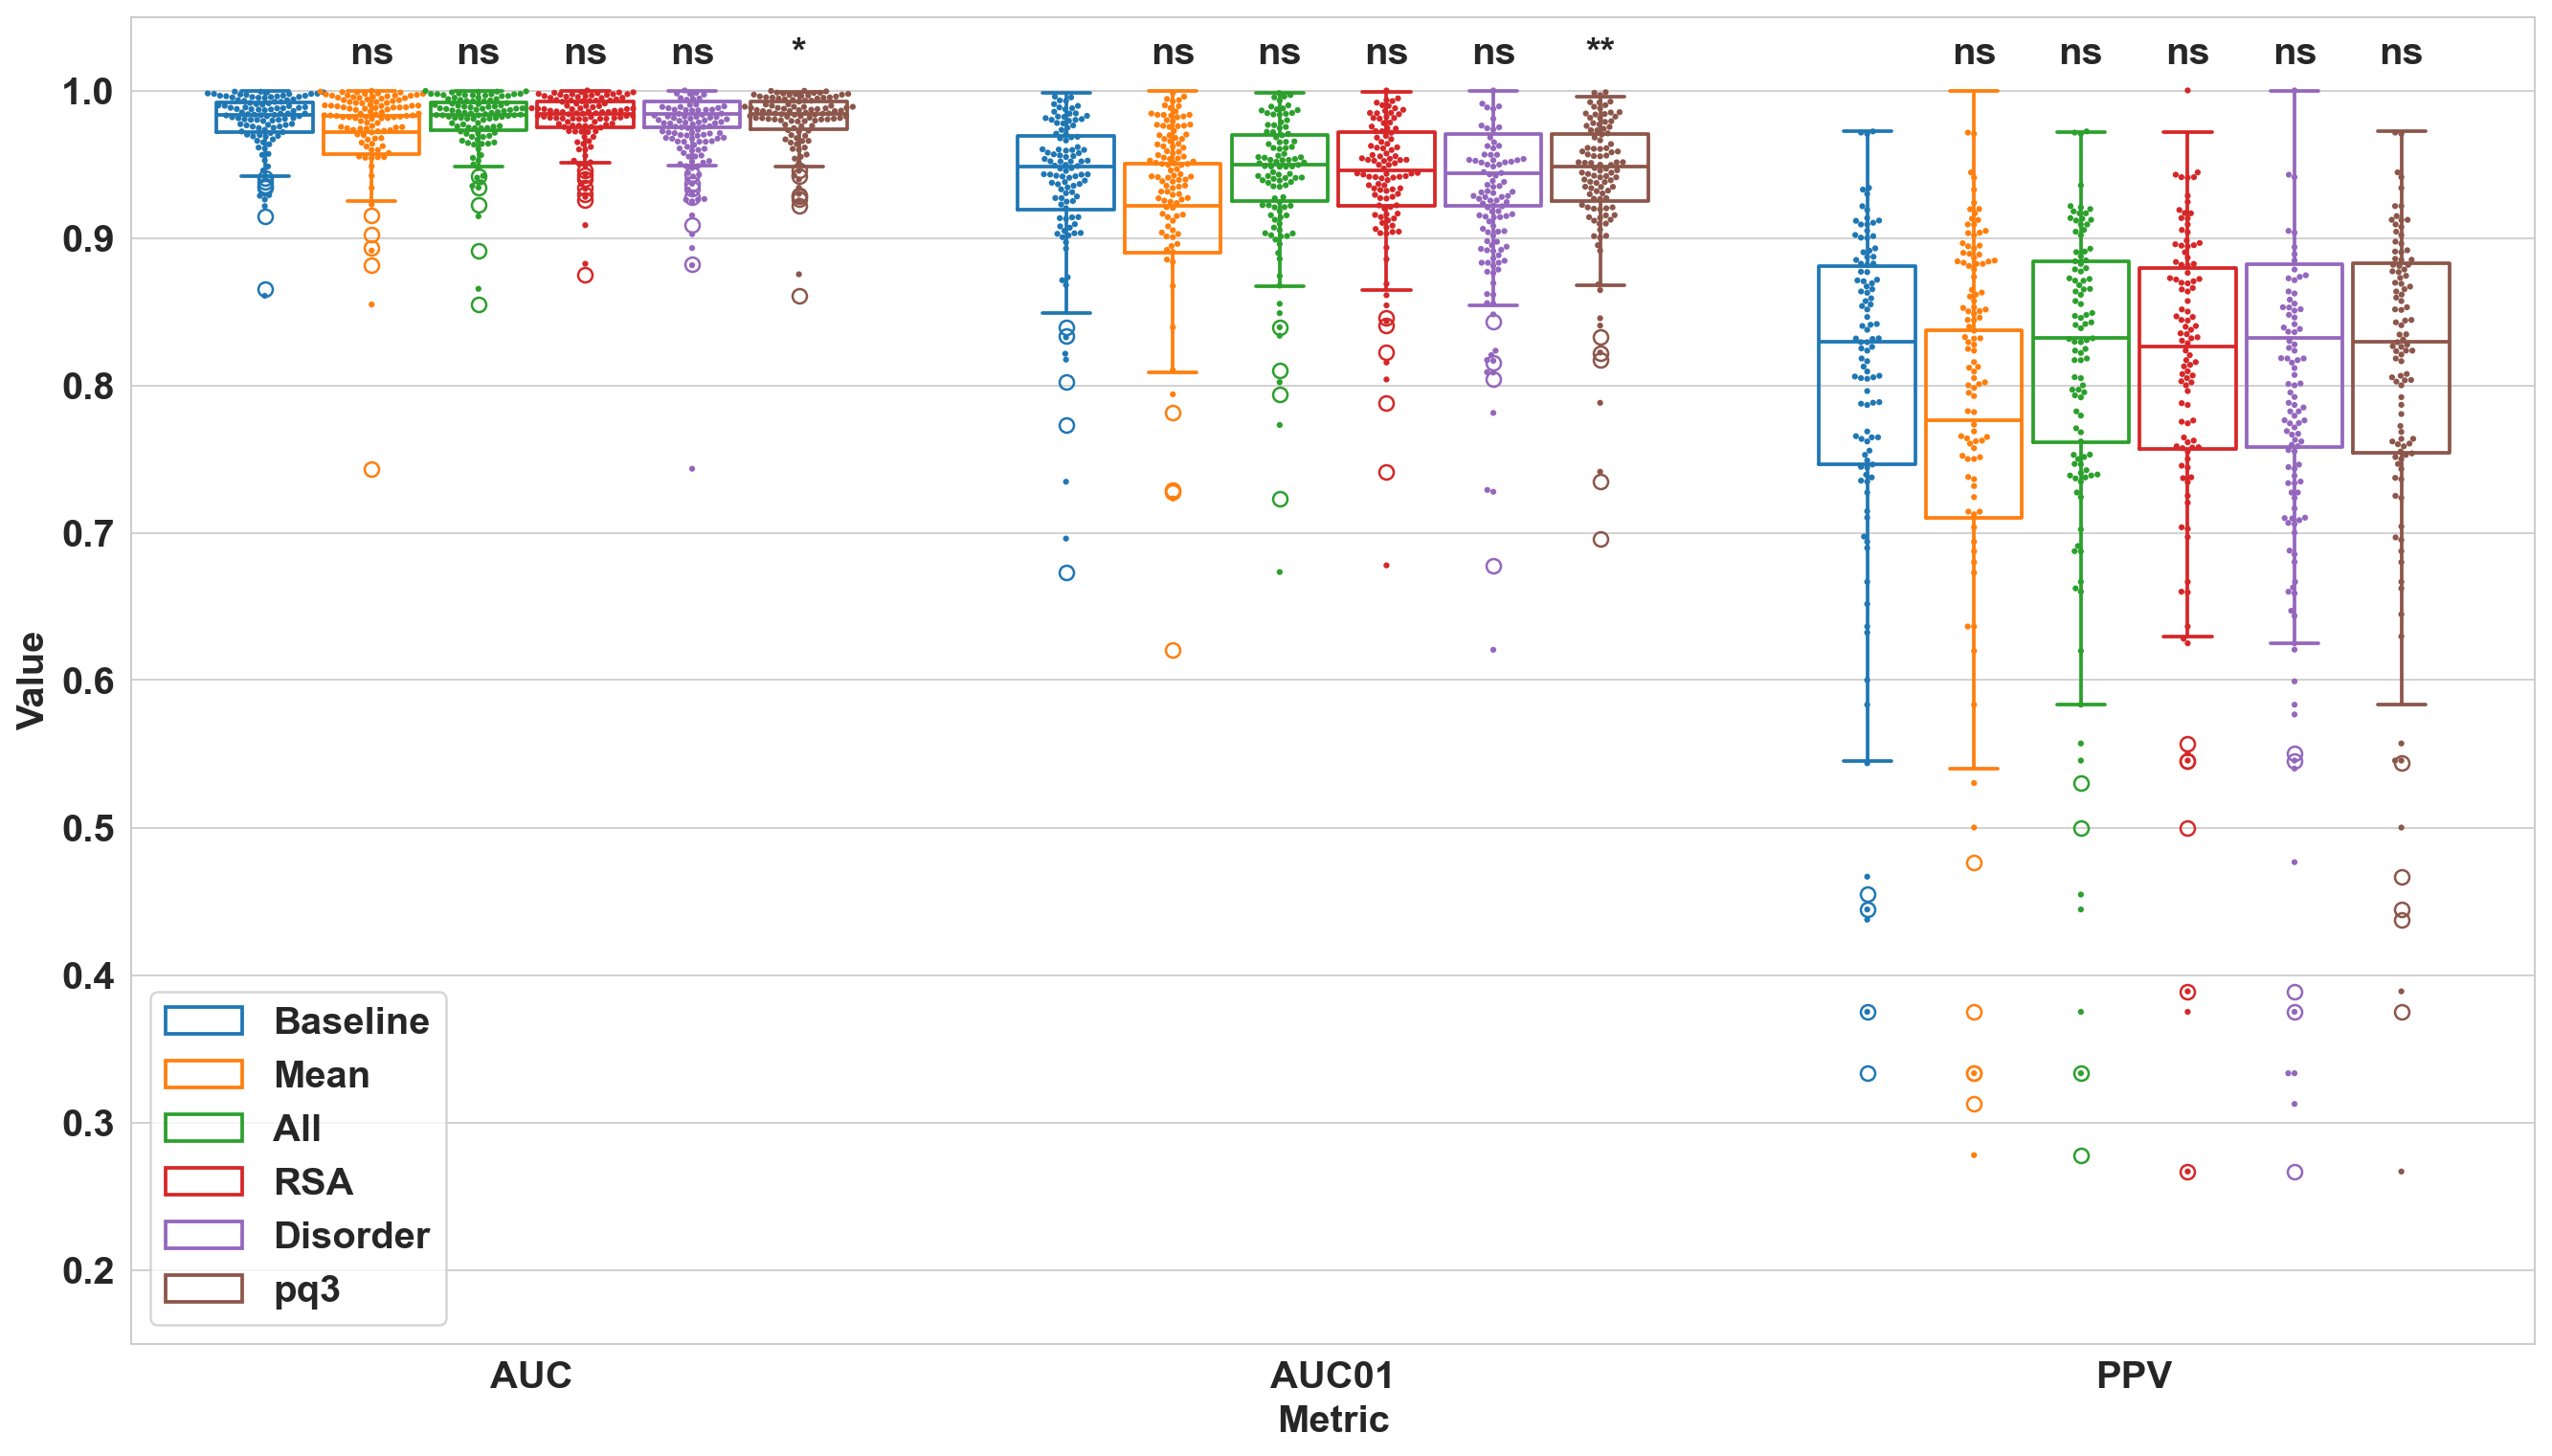

In [6]:
files = glob.glob(f'{DD}*MHCI_valid*')
fn='MHC1_KCV'
mhc1_kcv = pd.concat([read_result(f) for f in files])
mhc1_kcv_pvs, mhc1_kcv_sgs,_ = make_box(mhc1_kcv, figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc1_kcv_pvs)

### Test set (I)

,auc_pval,auc01_pval,ppv_pval
Mean,1.000000,1.000000,1.000000
All,0.087643,0.054428,0.990671
RSA,0.866094,0.356115,0.999995
Disorder,0.548921,0.730709,0.999995
pq3,0.945572,0.730709,0.982209


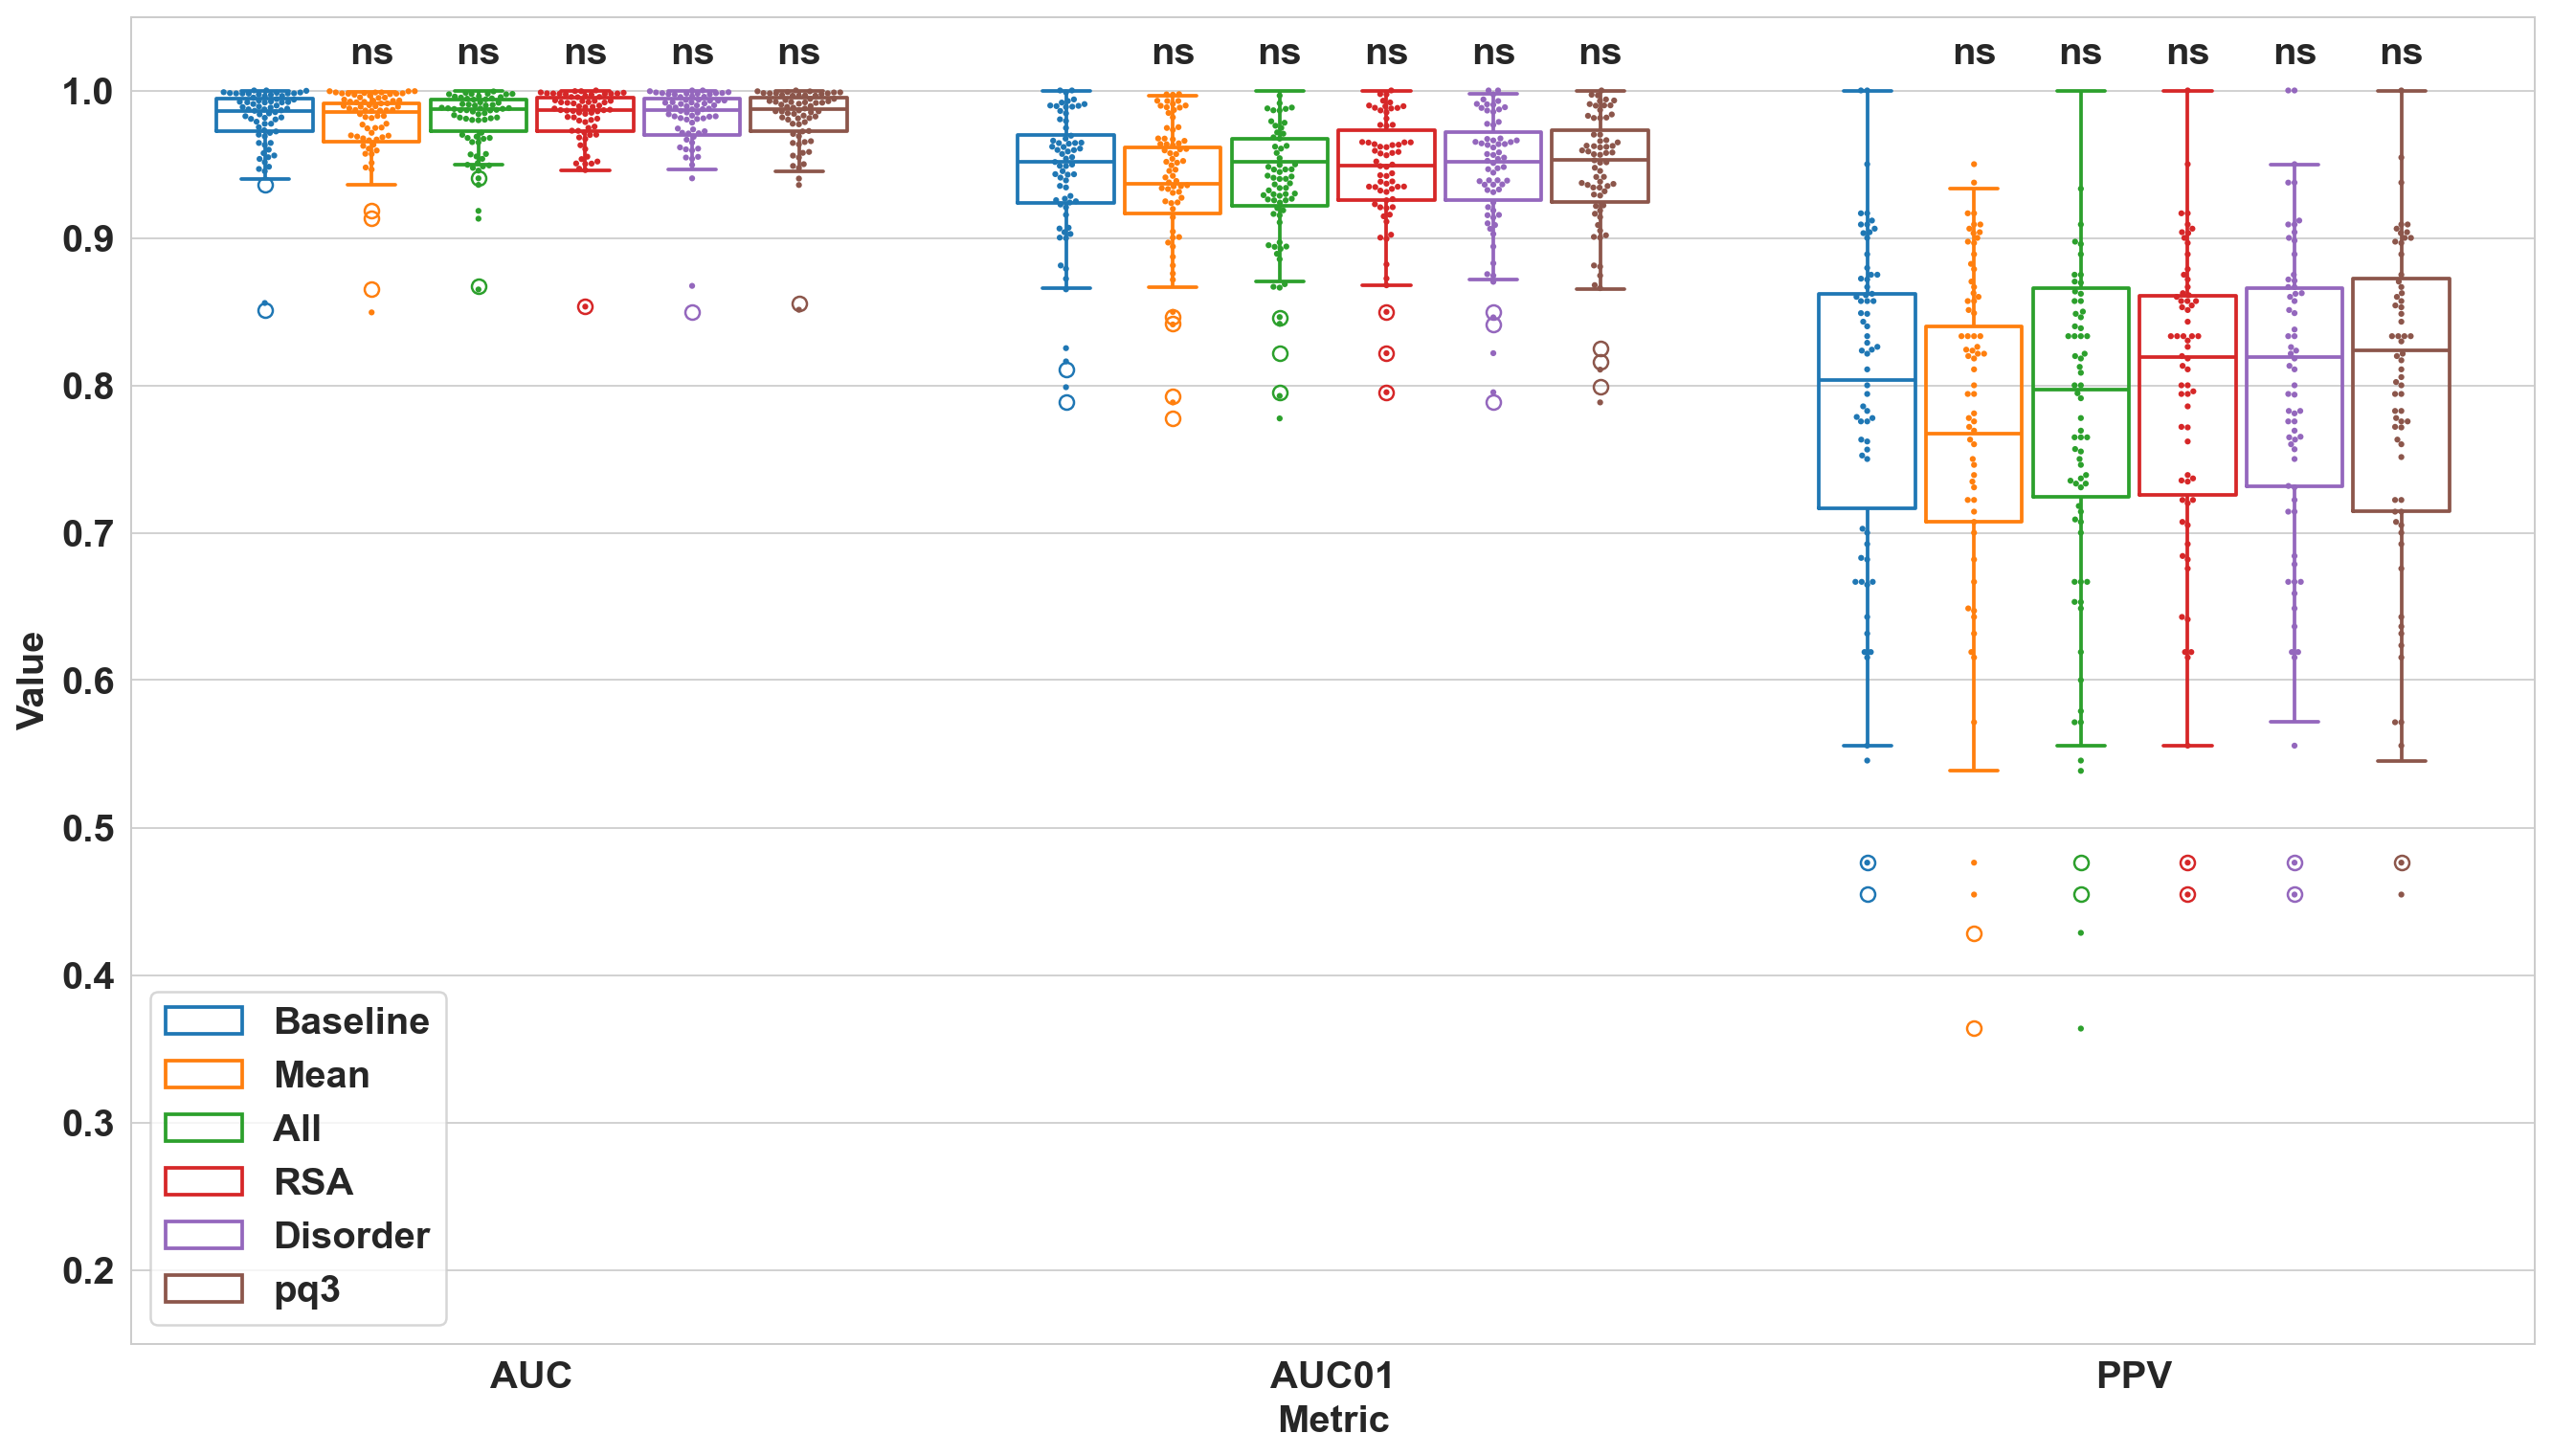

In [8]:
files = glob.glob(f'{DD}*MHCI_ensemble_test*')
fn='MHC1_Test'
mhc1_test = pd.concat([read_result(f) for f in files])
do_binom(mhc1_test)
mhc1_test_pvs, mhc1_test_sgs,_ = make_box(mhc1_test,  figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc1_test_pvs)

## Class II

### KCV (II)

In [14]:
glob.glob(f'{DD}*DR_valid*.csv')

['../output/250218_StructAll_results_REREDONE/HLA-DR_valid_mean_struct_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_baseline_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_pq3_only_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_rsa_only_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_disorder_only_per_HLA_all_partitions_concat.csv',
 '../output/250218_StructAll_results_REREDONE/HLA-DR_valid_pos_struct_per_HLA_all_partitions_concat.csv']

,auc_pval,auc01_pval,ppv_pval
Mean,1.000000,1.000000,1.000000
All,0.000008,0.000008,0.003958
RSA,0.044215,0.044215,0.082075
Disorder,0.044215,0.321984,0.139978
pq3,0.001444,0.021779,0.021779


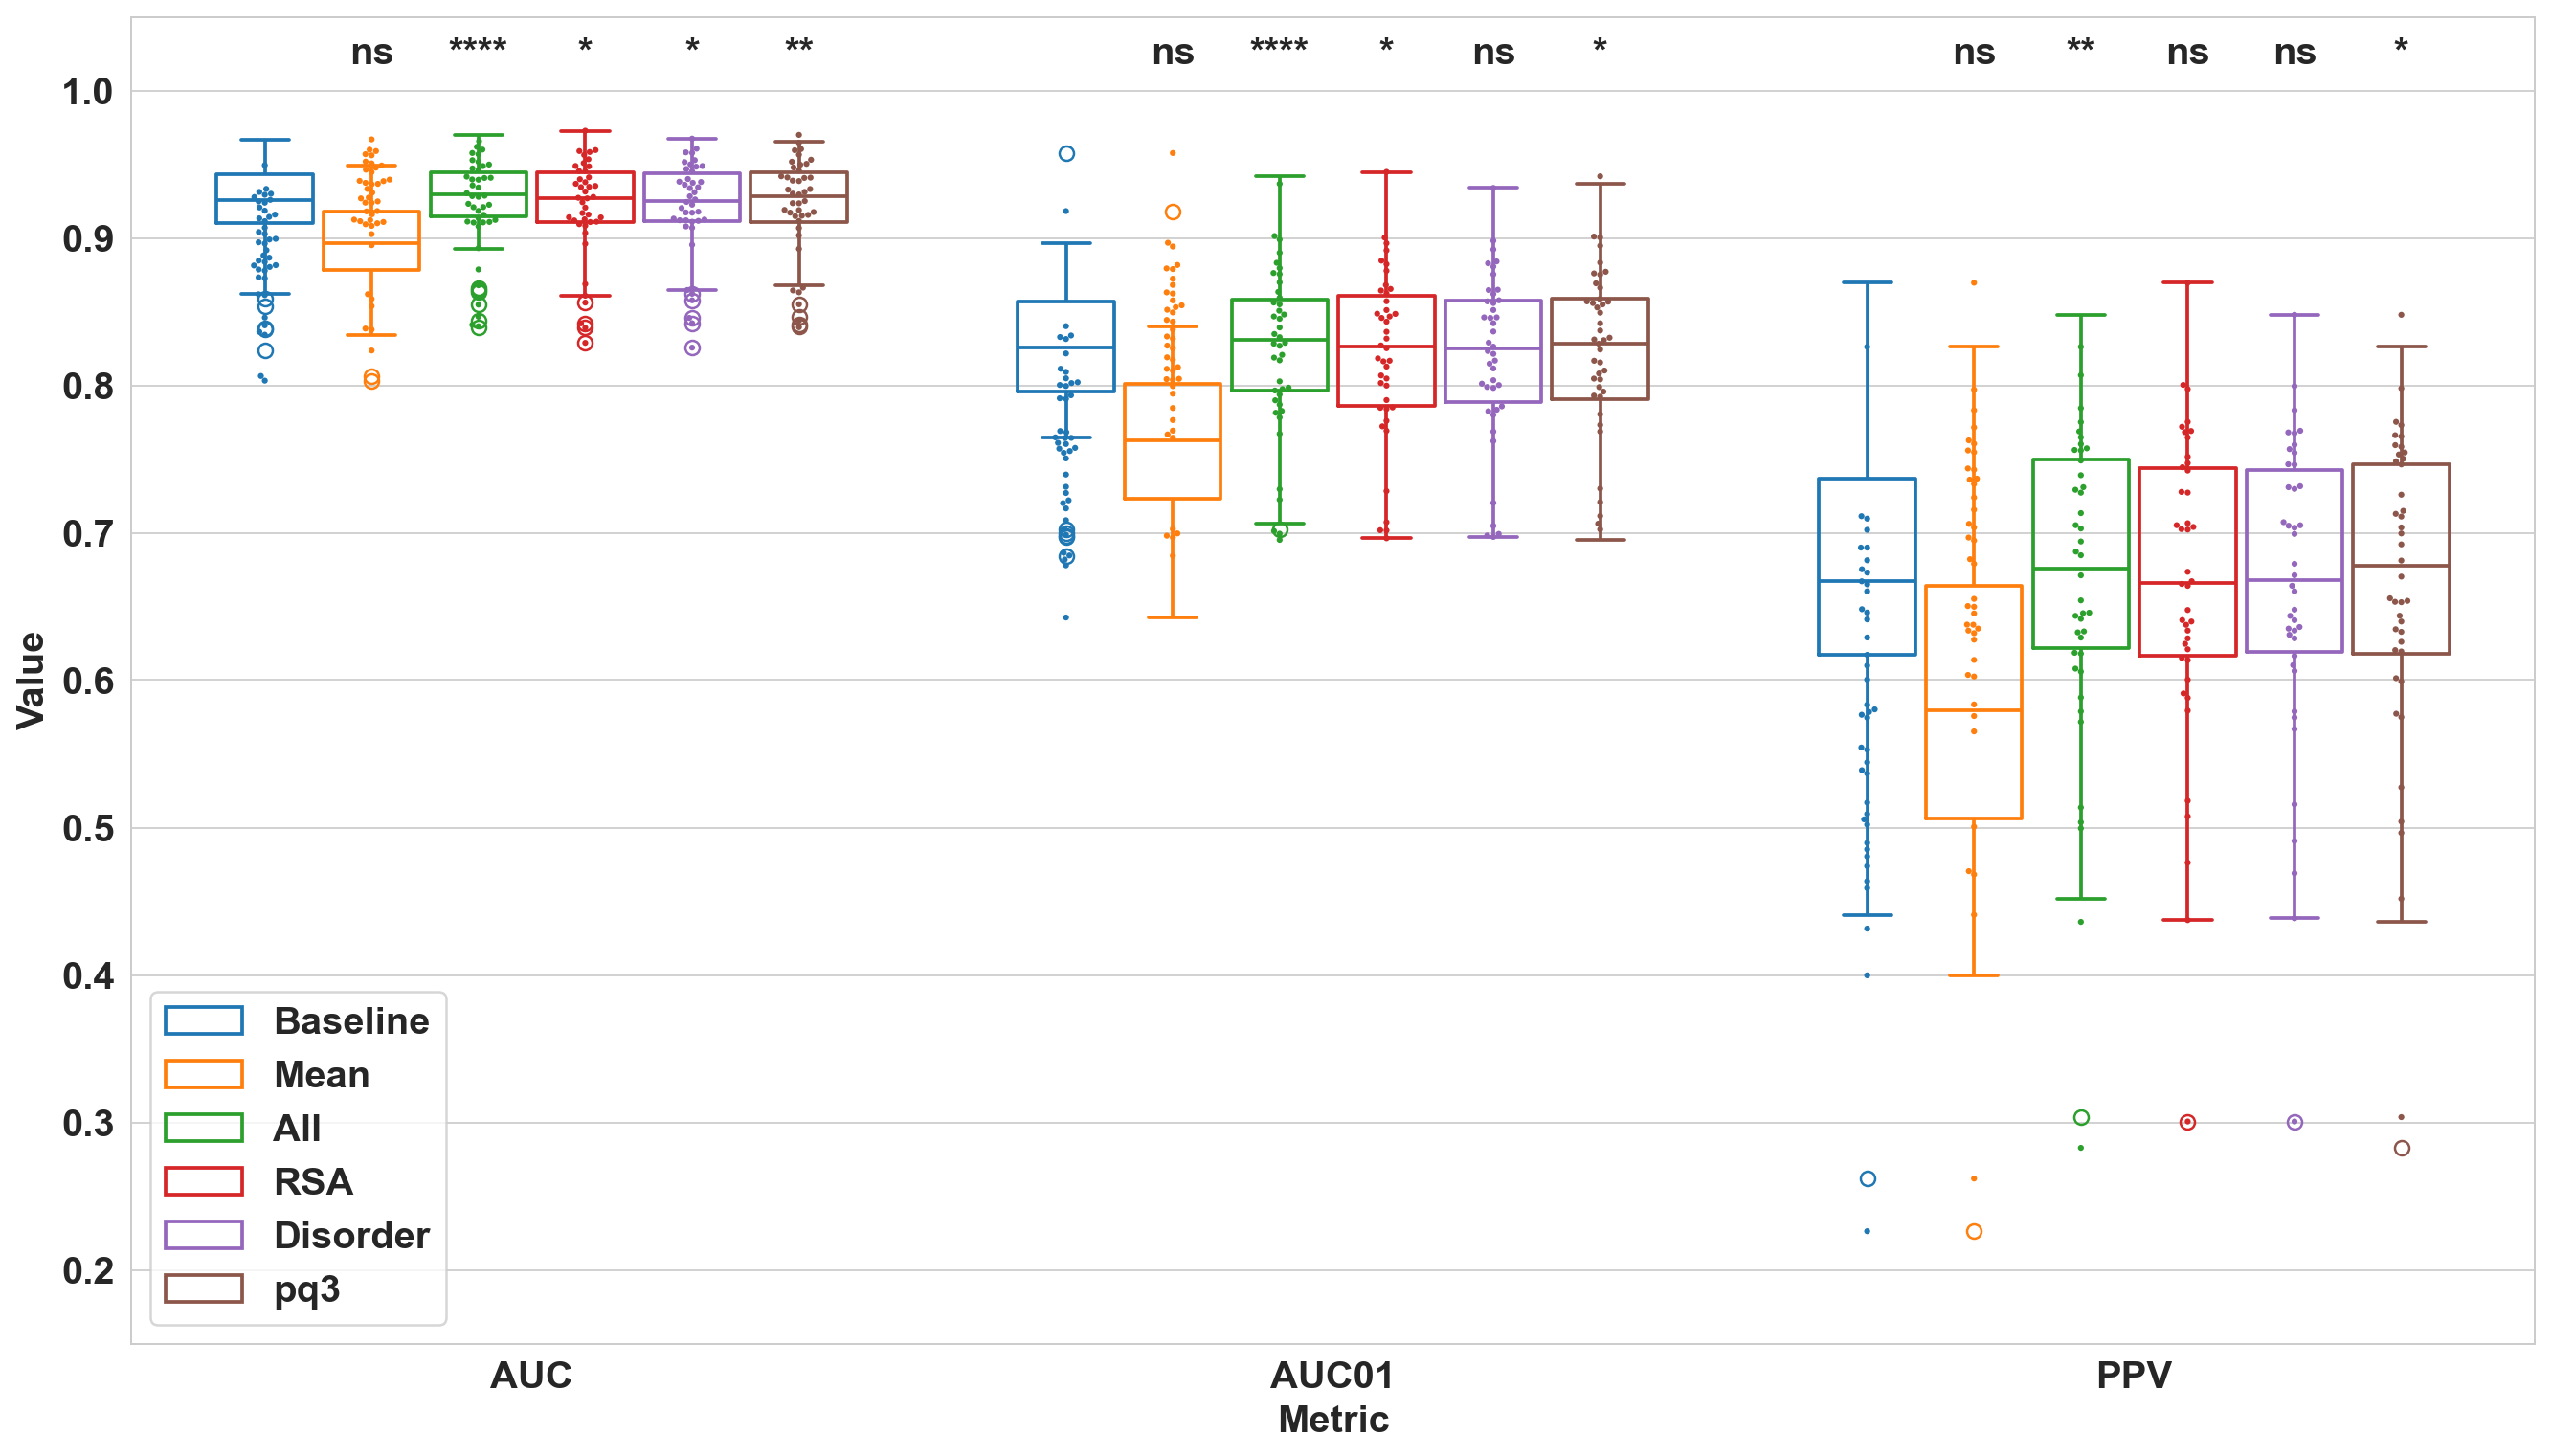

In [15]:
files = glob.glob(f'{DD}*DR_valid*.csv')
fn='HLA-DR_KCV'
mhc2_kcv = pd.concat([read_result(f) for f in files])
mhc2_kcv_pvs, mhc2_kcv_sgs,_ = make_box(mhc2_kcv,  figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc2_kcv_pvs)

### Test set (II)

,auc_pval,auc01_pval,ppv_pval
Mean,0.894488,1.000000,1.000000
All,0.058638,0.029792,0.029792
RSA,0.970208,0.733645,0.500000
Disorder,1.000000,1.000000,1.000000
pq3,0.266355,0.733645,0.500000


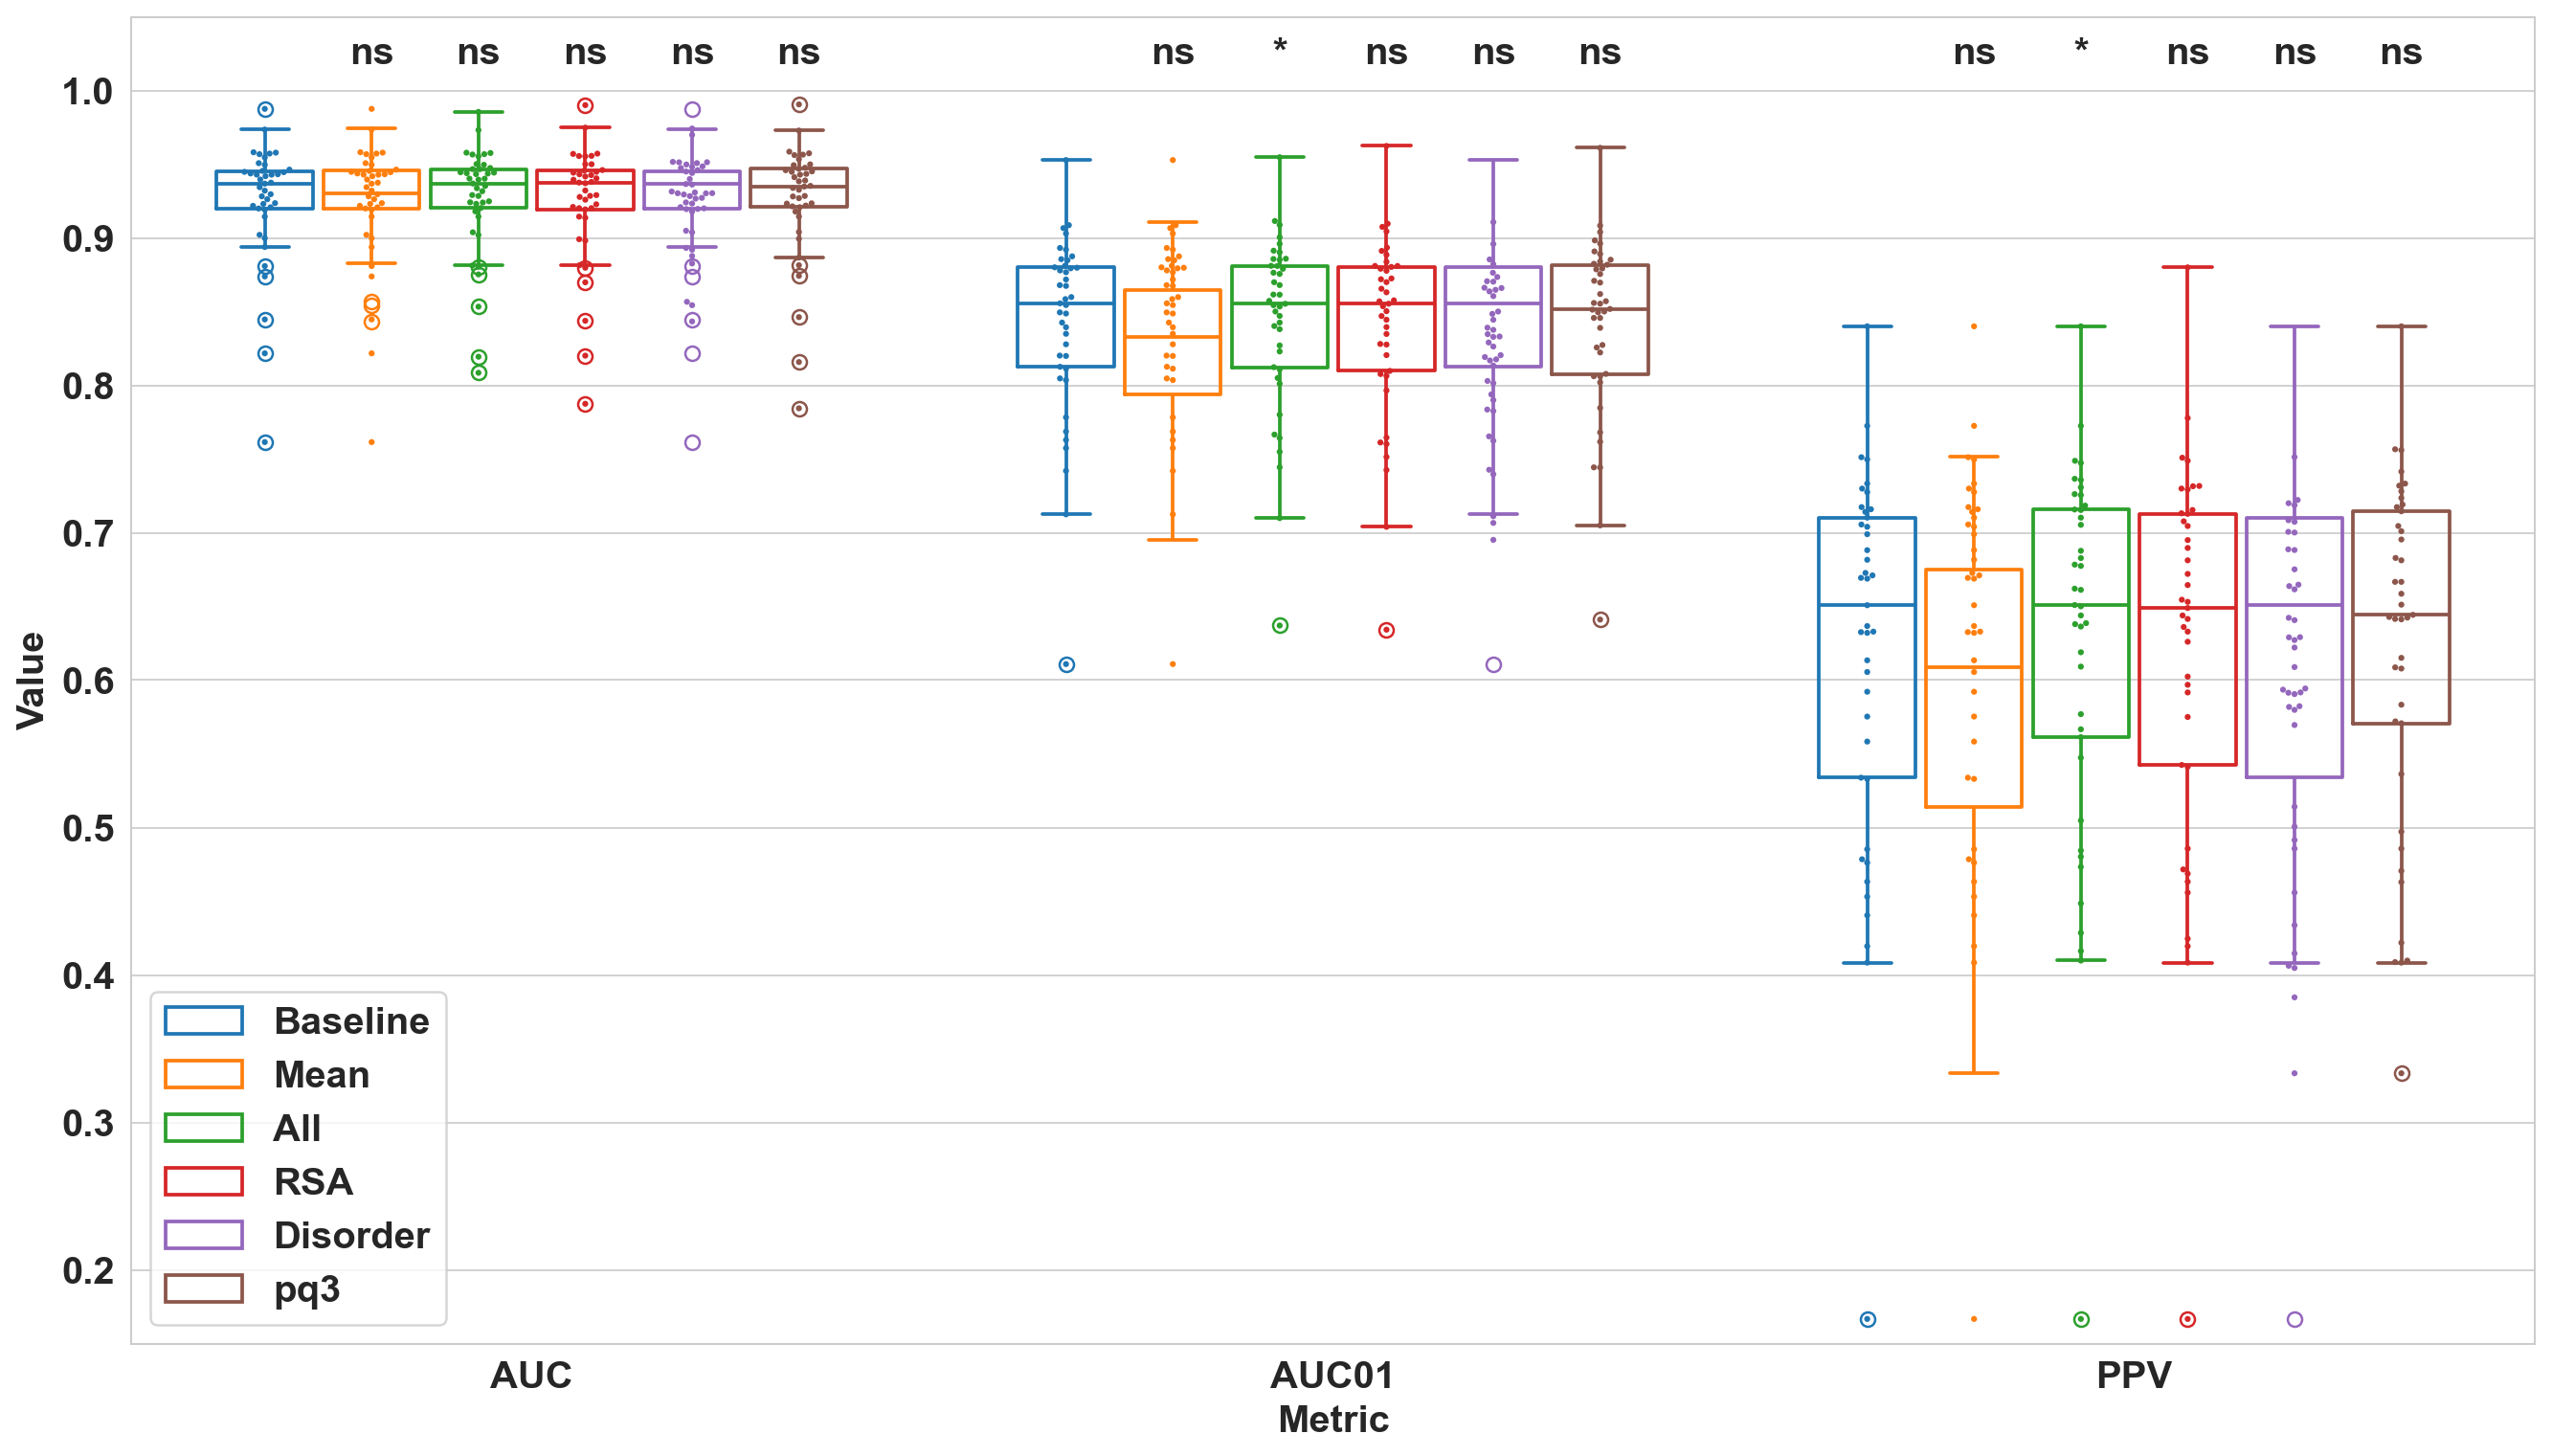

In [17]:
files = glob.glob(f'{DD}*DR_ensemble_test*.csv')
mhc2_test = pd.concat([read_result(f) for f in files])
fn='HLA-DR_Test'
do_binom(mhc2_test)
mhc2_test_pvs, mhc2_test_sgs, _ = make_box(mhc2_test,  figsize, saturation, alpha, width, size, swarm, fill, fn)
display(mhc2_test_pvs)

## pvals and enrichment stuff

In [80]:
a=mhc2_kcv.query('model=="baseline"').set_index('MHC')[['auc', 'auc01', 'ppv']]
b=mhc2_kcv.query('model=="pos_struct"').set_index('MHC')[['auc', 'auc01', 'ppv']]
(b>a).query('auc01')

,auc,auc01,ppv
MHC,,,
DRB1_0101,True,True,True
DRB1_0102,True,True,True
DRB1_0103,True,True,True
DRB1_0301,True,True,True
DRB1_0302,True,True,True
DRB1_0401,True,True,True
DRB1_0403,False,True,False
DRB1_0404,True,True,False
DRB1_0407,True,True,False


In [81]:
# get enriched list (for Delta AUC01 > threshold) vs non enriched list
(b-a).query('auc01>2.5e-3').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_validset_delta_AUC01_2.5e-3_allele_list.txt', header=False, index=False)
(b>a).query('not auc01').reset_index()['MHC'].to_csv(f'{DD}NOT_ENRICHED_HLA_DR_validset_allele_list.txt', header=False, index=False)
(b>a).query('auc01').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_validset_all_delta_AUC01_allele_list.txt', header=False, index=False)

In [191]:
binomtest(26,41, alternative="greater")

BinomTestResult(k=26, n=41, alternative='greater', statistic=0.6341463414634146, pvalue=0.05863760297870613)

In [196]:
(d>c).apply(lambda x: binomtest(x.sum(), x.count(), alternative="greater").pvalue)

auc      0.058638
auc01    0.029792
ppv      0.029792
dtype: float64

In [82]:
c=mhc2_test.query('model=="baseline"').set_index('MHC')[['auc', 'auc01', 'ppv']]
d=mhc2_test.query('model=="pos_struct"').set_index('MHC')[['auc', 'auc01', 'ppv']]
(d>c).query('auc01')

,auc,auc01,ppv
MHC,,,
DRB1_0101,True,True,True
DRB1_0102,False,True,True
DRB1_0103,False,True,False
DRB1_0301,True,True,True
DRB1_0401,True,True,True
DRB1_0403,True,True,True
DRB1_0404,True,True,True
DRB1_0407,True,True,True
DRB1_0701,True,True,True


In [83]:
(d>c).query('auc01')

,auc,auc01,ppv
MHC,,,
DRB1_0101,True,True,True
DRB1_0102,False,True,True
DRB1_0103,False,True,False
DRB1_0301,True,True,True
DRB1_0401,True,True,True
DRB1_0403,True,True,True
DRB1_0404,True,True,True
DRB1_0407,True,True,True
DRB1_0701,True,True,True


In [220]:
len((d>c).query('auc01'))

27

In [84]:
# get enriched list (for Delta AUC01 > threshold) vs non enriched list
(d-c).query('auc01>2.5e-3').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_testset_delta_AUC01_2.5e-3_allele_list.txt', header=False, index=False)
(d>c).query('not auc01').reset_index()['MHC'].to_csv(f'{DD}NOT_ENRICHED_HLA_DR_testset_allele_list.txt', header=False, index=False)
(d>c).query('auc01').reset_index()['MHC'].to_csv(f'{DD}enriched_HLA_DR_testset_all_delta_AUC01_allele_list.txt', header=False, index=False)

# ?

In [79]:
%wc -l $DD

UsageError: Line magic function `%wc` not found.


In [7]:
%ls $DD | grep enrich

enriched_HLA_DR_testset_all_delta_AUC01_allele_list.txt
enriched_HLA_DR_testset_delta_AUC01_2.5e-3_allele_list.txt
enriched_HLA_DR_validset_all_delta_AUC01_allele_list.txt
enriched_HLA_DR_validset_delta_AUC01_2.5e-3_allele_list.txt


In [8]:
enrich_test = pd.read_csv(f'{DD}enriched_HLA_DR_testset_delta_AUC01_2.5e-3_allele_list.txt')
enrich_kcv = pd.read_csv(f'{DD}enriched_HLA_DR_validset_delta_AUC01_2.5e-3_allele_list.txt')

In [78]:
%cat $DD/enriched_HLA_DR_validset_all_delta_AUC01_allele_list.txt



DRB1_0101
DRB1_0102
DRB1_0103
DRB1_0301
DRB1_0302
DRB1_0401
DRB1_0403
DRB1_0404
DRB1_0407
DRB1_0408
DRB1_0701
DRB1_0801
DRB1_0802
DRB1_0803
DRB1_0804
DRB1_0901
DRB1_1101
DRB1_1102
DRB1_1104
DRB1_1301
DRB1_1302
DRB1_1303
DRB1_1401
DRB1_1402
DRB1_1454
DRB1_1501
DRB1_1502
DRB1_1503
DRB1_1601
DRB3_0101
DRB3_0202
DRB3_0301
DRB4_0101
DRB5_0101
DRB5_0202


In [76]:
enrich_kcv

,DRB1_0101
0,DRB1_0102
1,DRB1_0103
2,DRB1_0301
3,DRB1_0302
4,DRB1_0401
5,DRB1_0407
6,DRB1_0408
7,DRB1_0701
8,DRB1_0801
9,DRB1_0802


In [9]:
%ls $DD/features

HLA-DR_aacomp_kcv_out_merged.csv     do_get_aa_composition.out_ratio
HLA-DR_aacomp_test_out_merged.csv    do_get_aa_composition_val*
do_get_aa_composition*               do_get_aa_composition_val.out
do_get_aa_composition.out            do_get_aa_composition_val.out_ratio


In [10]:
test_ratios = pd.read_csv(f'{DD}features/do_get_aa_composition.out_ratio', sep=' ', header=None, names=['AA', 'log(E_nE)'])
test_raw = pd.read_csv(f'{DD}features/do_get_aa_composition.out', sep=' ',header=None, names=['AA', 'n_E', 'freq_E', 'n_total_E', 'n_nE', 'freq_nE', 'n_total_nE'])
kcv_ratios = pd.read_csv(f'{DD}features/do_get_aa_composition_val.out_ratio', sep=' ', header=None, names=['AA', 'log(E_nE)'])
kcv_raw = pd.read_csv(f'{DD}features/do_get_aa_composition_val.out', sep=' ', header=None, names=['AA', 'n_E', 'freq_E', 'n_total_E', 'n_nE', 'freq_nE', 'n_total_nE'])
test_raw['n_total_E'] = test_raw['n_total_E'].apply(lambda x: int(x.split('\t')[0]))
kcv_raw['n_total_E'] = kcv_raw['n_total_E'].apply(lambda x: int(x.split('\t')[0]))

dr_test=test_raw.merge(test_ratios, left_on=['AA'], right_on=['AA'])
dr_kcv=kcv_raw.merge(kcv_ratios, left_on=['AA'], right_on=['AA'])

In [111]:
dr_test.to_csv(f'{DD}/features/HLA-DR_aacomp_test_out_merged.csv')
dr_kcv.to_csv(f'{DD}/features/HLA-DR_aacomp_kcv_out_merged.csv')

In [11]:
dr_test.tail()

,AA,n_E,freq_E,n_total_E,n_nE,freq_nE,n_total_nE,log(E_nE)
15,S,1905,0.063500,30000,1527,0.054536,28000,0.152184
16,T,1313,0.043767,30000,1108,0.039571,28000,0.100767
17,V,2850,0.095000,30000,2357,0.084179,28000,0.120936
18,W,196,0.006533,30000,220,0.007857,28000,-0.184506
19,Y,1787,0.059567,30000,2293,0.081893,28000,-0.318316


In [29]:
from scipy.stats import fisher_exact, barnard_exact, chi2_contingency, norm

a=196
b=220
n = 30000
m = 28000

se=np.sqrt(((1/a)-(1/n) + (1/b) - (1/m)))
z = np.log((a/n) / (b/m))/se
alt='greater' if pa>=pb else 'less'
print(fisher_exact([[a, 30000-a],
              [b, 28000-b]], alternative=alt).pvalue)
print(chi2_contingency([[a, 30000-a],
                        [b, 28000-b]]).pvalue)
# For a two-sided test:
p_value = 2 * (1 - norm.cdf(abs(z)))
# For a one-sided test:
p_value_one_sided = 1 - norm.cdf(z)  # if testing for a positive effect
p_value_one_sided_b = norm.cdf(z)  # if testing for a positive effect
print(p_value)
print(p_value_one_sided)
print(p_value_one_sided_b)

0.03301556288660497
0.06596284107911722
0.0593999542944188
0.9703000228527906
0.029699977147209435


In [17]:
from src.data_processing import AA_KEYS
AA_KEYS
dr_merged = pd.merge(dr_test.rename(columns={'log(E_nE)':'aa_enrichment'}), 
                     dr_kcv.rename(columns={'log(E_nE)':'aa_enrichment'}), 
                     left_on=['AA'], right_on=['AA'], suffixes=('_test', '_KCV'))
display(dr_merged.head())
dr_melted = dr_merged.melt(id_vars=['AA'], value_vars=['aa_enrichment_test', 'aa_enrichment_KCV',
                                                       'freq_E_test', 'freq_nE_test', 'freq_E_KCV', 'freq_nE_KCV'])

,AA,n_E_test,freq_E_test,n_total_E_test,n_nE_test,freq_nE_test,n_total_nE_test,aa_enrichment_test,n_E_KCV,freq_E_KCV,n_total_E_KCV,n_nE_KCV,freq_nE_KCV,n_total_nE_KCV,aa_enrichment_KCV
0,A,2859,0.095300,30000,2338,0.083500,28000,0.132183,5642,0.097276,58000,1165,0.083214,14000,0.156132
1,C,23,0.000767,30000,21,0.000750,28000,0.021979,52,0.000897,58000,6,0.000429,14000,0.738100
2,D,1544,0.051467,30000,1813,0.064750,28000,-0.229599,2883,0.049707,58000,1144,0.081714,14000,-0.497085
3,E,703,0.023433,30000,1252,0.044714,28000,-0.646135,1408,0.024276,58000,483,0.034500,14000,-0.351475
4,F,1932,0.064400,30000,2230,0.079643,28000,-0.212439,4401,0.075879,58000,852,0.060857,14000,0.220615


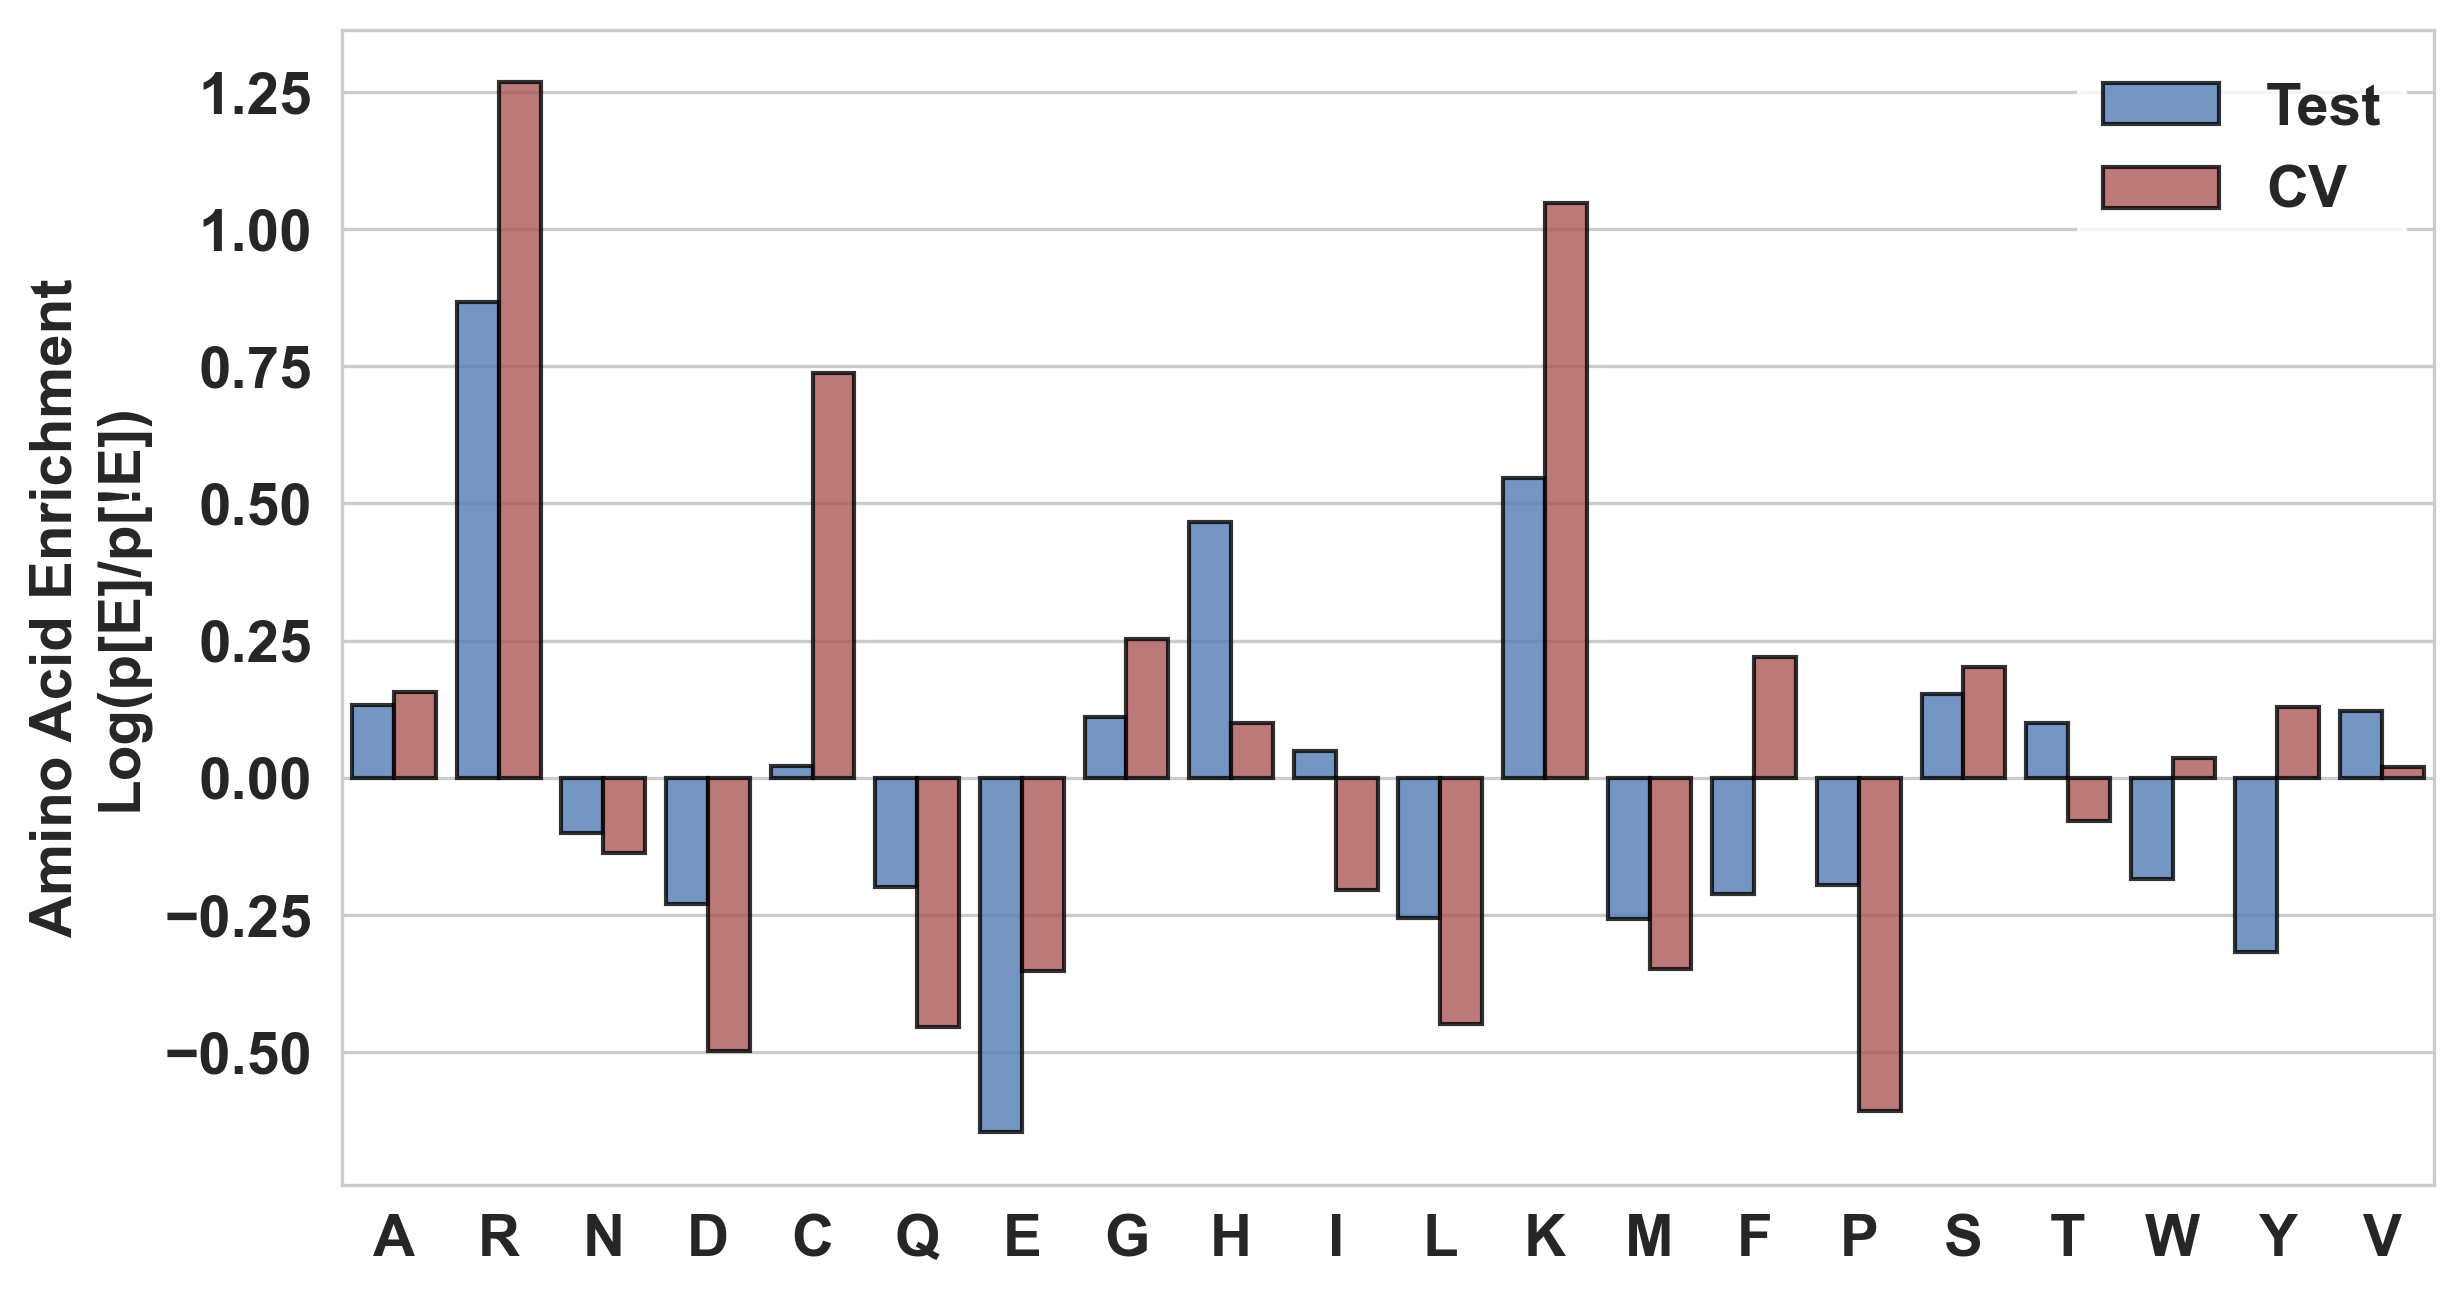

In [436]:
# pal=sns.color_palette('tab10', 10)
# sns.set_palette([pal[0], pal[3]])
pal=sns.color_palette('vlag', 15)
sns.set_palette([pal[0], pal[-1]])
fw, fs = 'semibold', 14
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.barplot(dr_melted.replace({'aa_enrichment_test':'Test', 'aa_enrichment_KCV':'CV'})\
                     .rename(columns={'variable':'Dataset', 'value':'AA Enrichment'}), 
            x='AA', y='AA Enrichment', hue='Dataset', hue_order=['Test', 'CV'],
            order=AA_KEYS, ax=ax, saturation=.85, alpha=.8, edgecolor='k', gap=0)
ax.set_xlabel(None)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fs, fontweight=fw)
ax.legend(prop={'weight':fw, 'size':fs},  edgecolor='w')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fs, fontweight=fw)
ax.set_ylabel('Amino Acid Enrichment\nLog(p[E]/p[!E])', fontsize=fs, fontweight=fw)
fig.savefig('../../../writing/pynnalign_draft/figure/HLA-DR_aa_enrichment.png', dpi=300, bbox_inches='tight')

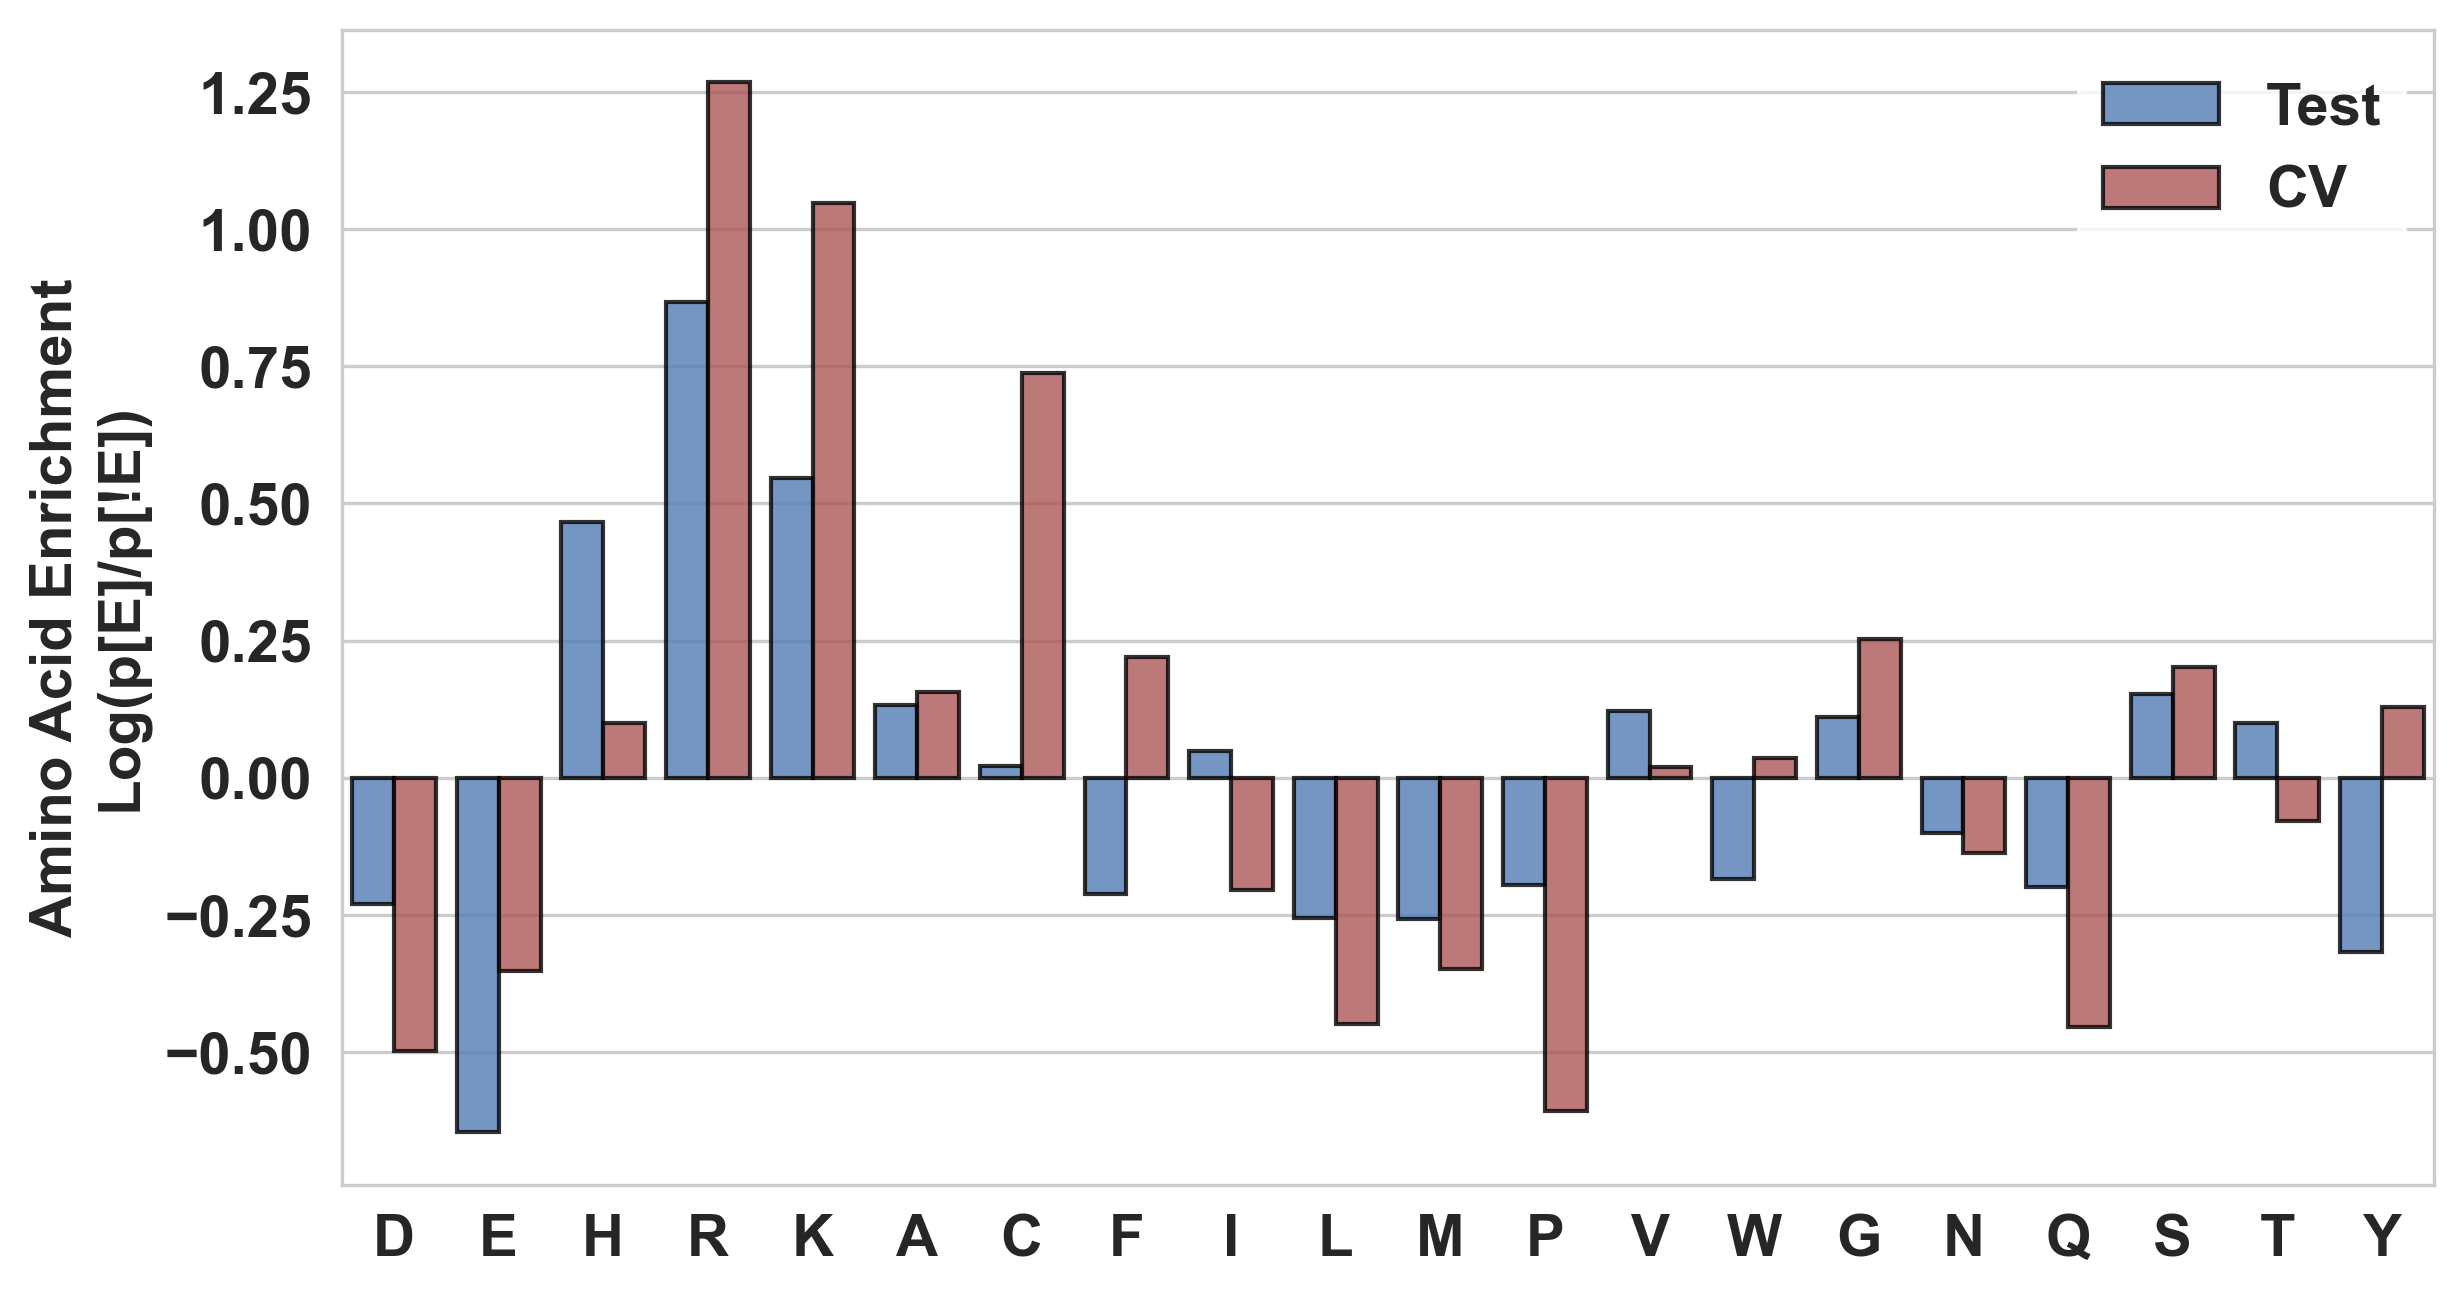

In [18]:
aa_groups = {
        'Acidic': set("DE"),
        'Basic': set("HRK"),
        'Hydrophobic': set("ACFILMPVW"),
        'Neutral': set("GNQSTY")
}
reorder = [x for x in 'DEHRKACFILMPVWGNQSTY']
pal=sns.color_palette('vlag', 15)
sns.set_palette([pal[0], pal[-1]])
fw, fs = 'semibold', 14
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.barplot(dr_melted.replace({'aa_enrichment_test':'Test', 'aa_enrichment_KCV':'CV'})\
                     .rename(columns={'variable':'Dataset', 'value':'AA Enrichment'}), 
            x='AA', y='AA Enrichment', hue='Dataset', hue_order=['Test', 'CV'],
            order=reorder, ax=ax, saturation=.85, alpha=.8, edgecolor='k', gap=0)
ax.set_xlabel(None)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=fs, fontweight=fw)
ax.legend(prop={'weight':fw, 'size':fs},  edgecolor='w')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=fs, fontweight=fw)
ax.set_ylabel('Amino Acid Enrichment\nLog(p[E]/p[!E])', fontsize=fs, fontweight=fw)
fig.savefig('../../../writing/pynnalign_draft/figure/HLA-DR_aa_enrichment_reorder.png', dpi=300, bbox_inches='tight')

# Do DeepLoc

In [190]:
pd.Series(test_2['Prot_ID'].unique()).to_csv('../data/NetMHCII_EL_jonas/HLA_DR_test_500k_unique_prot_ids.txt', index=False, header=False)

In [14]:
locs = pd.read_csv('../data/NetMHCII_EL_jonas/results_20250315-163922.csv')
locs['Prot_ID'] = locs['Protein_ID'].apply(lambda x: x.split('|')[1])
locs

,Protein_ID,Localizations,Signals,Membrane types,Cytoplasm,Nucleus,Extracellular,Cell membrane,Mitochondrion,Plastid,Endoplasmic reticulum,Lysosome/Vacuole,Golgi apparatus,Peroxisome,Peripheral,Transmembrane,Lipid anchor,Soluble,Prot_ID
0,sp|Q60888|10D1B_MOUSE,Cell membrane,Transmembrane domain,Transmembrane,0.1664,0.1303,0.0208,0.8638,0.2046,0.0114,0.1100,0.2164,0.0845,0.0200,0.0707,0.9941,0.0423,0.1288,Q60888
1,sp|Q8VBW9|10H28_MOUSE,Cell membrane,Transmembrane domain,Transmembrane,0.1634,0.1614,0.0329,0.9099,0.1884,0.0051,0.1394,0.2457,0.0746,0.0179,0.0757,0.9949,0.0418,0.1255,Q8VBW9
2,sp|Q60885|10P22_MOUSE,Cell membrane,Transmembrane domain,Transmembrane,0.1414,0.1512,0.0272,0.9119,0.2540,0.0057,0.1047,0.2764,0.0791,0.0138,0.0806,0.9927,0.0394,0.1553,Q60885
3,sp|P31946|1433B_HUMAN,Cytoplasm|Nucleus,Nuclear export signal,Soluble,0.7828,0.5551,0.0324,0.2618,0.1140,0.0005,0.1080,0.3278,0.1046,0.0854,0.4681,0.0125,0.1419,0.8637,P31946
4,sp|Q9CQV8|1433B_MOUSE,Cytoplasm|Nucleus,Nuclear export signal,Soluble,0.7861,0.5603,0.0309,0.2518,0.1112,0.0005,0.1100,0.3270,0.1068,0.0803,0.4714,0.0129,0.1485,0.8624,Q9CQV8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30230,sp|Q15942|ZYX_HUMAN,Cytoplasm,Nuclear export signal,Peripheral|Soluble,0.7908,0.3192,0.0773,0.2598,0.0934,0.0014,0.1515,0.2972,0.3580,0.0019,0.6728,0.0275,0.2091,0.8279,Q15942
30231,sp|Q62523|ZYX_MOUSE,Cytoplasm,Nuclear export signal,Peripheral|Soluble,0.7992,0.3189,0.0691,0.2720,0.0915,0.0016,0.1524,0.3242,0.3516,0.0021,0.6677,0.0253,0.2191,0.8330,Q62523
30232,sp|O43149|ZZEF1_HUMAN,Cytoplasm,Nuclear localization signal|Nuclear export signal,Peripheral|Lipid anchor|Soluble,0.5324,0.5097,0.0505,0.2934,0.2412,0.0081,0.2573,0.4193,0.4558,0.0173,0.7318,0.0842,0.7409,0.5195,O43149
30233,sp|Q5SSH7|ZZEF1_MOUSE,Cytoplasm,Nuclear export signal,Peripheral|Lipid anchor|Soluble,0.5297,0.5204,0.0468,0.2815,0.2130,0.0085,0.2602,0.3747,0.4191,0.0219,0.7205,0.0792,0.7565,0.5273,Q5SSH7


In [15]:
a=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_0_250203_2303_IleIo/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f00_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_0_250203_2303_IleIo.csv')
b=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_1_250204_0005_IleIo/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f01_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_1_250204_0005_IleIo.csv')
c=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_2_250204_0005_IleIo/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f02_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_2_250204_0005_IleIo.csv')
d=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_3_250204_0005_IleIo/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f03_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_3_250204_0005_IleIo.csv')
e=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_4_250204_0310_IleIo/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f04_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_PerPositionStructure_KFold_4_250204_0310_IleIo.csv')

es = pd.concat([a.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(a))], model='a'),
                            b.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(b))], model='b'),
                            c.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(c))], model='c'),
                            d.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(d))], model='d'),
                            e.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(e))], model='e')])
ensemble_preds_structure = es.groupby(['seq_id']).agg(ensemble_pred=('pred','mean'),
                                            target=('target','mean'),
                                            sequence=('sequence','first'),
                                            rank=('rank_prediction','mean'),
                                            sample=('sample','first'),
                                            MHC=('MHC','first'),
                                            mhc_rel=('mhc_reliability','mean'),
                                            Prot_ID=('Prot_ID','first'))
ensemble_preds_structure

,ensemble_pred,target,sequence,rank,sample,MHC,mhc_rel,Prot_ID
seq_id,,,,,,,,
SEQ_0000000,0.024455,0.0,RIQKDHHQASNSSRLHT,8.242545,Racle__3808_HMC_DR,DRB1_0701,0.60,O94907
SEQ_0000001,0.003146,0.0,TFSALQILPYTLASLYHREKQ,18.861940,Racle__3830_NJF_DQP,DRB1_1101,0.60,Q96JT2
SEQ_0000002,0.011600,0.0,LSQLVNLYLGRSH,9.317119,Racle__TIL1,DRB4_0103,0.35,Q9BQ70
SEQ_0000003,0.020626,0.0,FDLRPGVIVRDLDLKKPIYQR,48.163578,Scally__DRB1_0402,DRB1_0402,1.00,P31153
SEQ_0000004,0.000020,0.0,KNCVLLGNICYNCGR,90.962227,Ooi__DR15_human,DRB1_1501,0.60,Q8WW36
...,...,...,...,...,...,...,...,...
SEQ_0499995,0.000813,0.0,GGPGGLKGPVWPAKEENSCSH,52.785919,Abelin__MAPTAC_DRB1_1501,DRB1_1501,1.00,Q6RVD6
SEQ_0499996,0.033741,0.0,FIERDLIEQATMVALEQAGR,10.563462,Racle__RA957,DRB1_0401,0.55,Q8TE49
SEQ_0499997,0.014373,0.0,NDFQCWEKGQASQITASNL,12.118920,Racle__CD165_DR,DRB1_1101,0.60,Q9BRX5


In [241]:
a=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_0_250203_1553_S7E7m/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f00_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_0_250203_1553_S7E7m.csv')
b=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_1_250203_1857_S7E7m/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f01_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_1_250203_1857_S7E7m.csv')
c=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_2_250203_1958_S7E7m/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f02_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_2_250203_1958_S7E7m.csv')
d=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_3_250203_1958_S7E7m/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f03_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_3_250203_1958_S7E7m.csv')
e=pd.read_csv('../output/250319_recopy_HLADR_results/RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_4_250203_1959_S7E7m/test_predictions_HLA_DR_500K_unseen_sequence_test_set_kcv_HLA_DR_subsample_all_partitions_922k_f04_RERUNS_FEB3_CORRECT_HYPERPARAMS-HLA_DR_baseline_KFold_4_250203_1959_S7E7m.csv')

es = pd.concat([a.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(a))], model='a'),
                            b.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(b))], model='b'),
                            c.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(c))], model='c'),
                            d.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(d))], model='d'),
                            e.assign(seq_id=[f'SEQ_{i:07}' for i in range(len(e))], model='e')])
ensemble_preds_baseline = es.groupby(['seq_id']).agg(ensemble_pred=('pred','mean'),
                                            target=('target','mean'),
                                            sequence=('sequence','first'),
                                            rank=('rank_prediction','mean'),
                                            sample=('sample','first'),
                                            MHC=('MHC','first'),
                                            mhc_rel=('mhc_reliability','mean'),
                                            Prot_ID=('Prot_ID','first'))
ensemble_preds_baseline

,ensemble_pred,target,sequence,rank,sample,MHC,mhc_rel,Prot_ID
seq_id,,,,,,,,
SEQ_0000000,0.029385,0.0,RIQKDHHQASNSSRLHT,8.242545,Racle__3808_HMC_DR,DRB1_0701,0.60,O94907
SEQ_0000001,0.006167,0.0,TFSALQILPYTLASLYHREKQ,18.861940,Racle__3830_NJF_DQP,DRB1_1101,0.60,Q96JT2
SEQ_0000002,0.011484,0.0,LSQLVNLYLGRSH,9.317119,Racle__TIL1,DRB4_0103,0.35,Q9BQ70
SEQ_0000003,0.018255,0.0,FDLRPGVIVRDLDLKKPIYQR,48.163578,Scally__DRB1_0402,DRB1_0402,1.00,P31153
SEQ_0000004,0.000027,0.0,KNCVLLGNICYNCGR,90.962227,Ooi__DR15_human,DRB1_1501,0.60,Q8WW36
...,...,...,...,...,...,...,...,...
SEQ_0499995,0.000269,0.0,GGPGGLKGPVWPAKEENSCSH,52.785919,Abelin__MAPTAC_DRB1_1501,DRB1_1501,1.00,Q6RVD6
SEQ_0499996,0.027656,0.0,FIERDLIEQATMVALEQAGR,10.563462,Racle__RA957,DRB1_0401,0.55,Q8TE49
SEQ_0499997,0.095583,0.0,NDFQCWEKGQASQITASNL,12.118920,Racle__CD165_DR,DRB1_1101,0.60,Q9BRX5


In [280]:
locs

,Protein_ID,Localizations,Signals,Membrane types,Cytoplasm,Nucleus,Extracellular,Cell membrane,Mitochondrion,Plastid,Endoplasmic reticulum,Lysosome/Vacuole,Golgi apparatus,Peroxisome,Peripheral,Transmembrane,Lipid anchor,Soluble,Prot_ID
0,sp|Q60888|10D1B_MOUSE,Cell membrane,Transmembrane domain,Transmembrane,0.1664,0.1303,0.0208,0.8638,0.2046,0.0114,0.1100,0.2164,0.0845,0.0200,0.0707,0.9941,0.0423,0.1288,Q60888
1,sp|Q8VBW9|10H28_MOUSE,Cell membrane,Transmembrane domain,Transmembrane,0.1634,0.1614,0.0329,0.9099,0.1884,0.0051,0.1394,0.2457,0.0746,0.0179,0.0757,0.9949,0.0418,0.1255,Q8VBW9
2,sp|Q60885|10P22_MOUSE,Cell membrane,Transmembrane domain,Transmembrane,0.1414,0.1512,0.0272,0.9119,0.2540,0.0057,0.1047,0.2764,0.0791,0.0138,0.0806,0.9927,0.0394,0.1553,Q60885
3,sp|P31946|1433B_HUMAN,Cytoplasm|Nucleus,Nuclear export signal,Soluble,0.7828,0.5551,0.0324,0.2618,0.1140,0.0005,0.1080,0.3278,0.1046,0.0854,0.4681,0.0125,0.1419,0.8637,P31946
4,sp|Q9CQV8|1433B_MOUSE,Cytoplasm|Nucleus,Nuclear export signal,Soluble,0.7861,0.5603,0.0309,0.2518,0.1112,0.0005,0.1100,0.3270,0.1068,0.0803,0.4714,0.0129,0.1485,0.8624,Q9CQV8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30230,sp|Q15942|ZYX_HUMAN,Cytoplasm,Nuclear export signal,Peripheral|Soluble,0.7908,0.3192,0.0773,0.2598,0.0934,0.0014,0.1515,0.2972,0.3580,0.0019,0.6728,0.0275,0.2091,0.8279,Q15942
30231,sp|Q62523|ZYX_MOUSE,Cytoplasm,Nuclear export signal,Peripheral|Soluble,0.7992,0.3189,0.0691,0.2720,0.0915,0.0016,0.1524,0.3242,0.3516,0.0021,0.6677,0.0253,0.2191,0.8330,Q62523
30232,sp|O43149|ZZEF1_HUMAN,Cytoplasm,Nuclear localization signal|Nuclear export signal,Peripheral|Lipid anchor|Soluble,0.5324,0.5097,0.0505,0.2934,0.2412,0.0081,0.2573,0.4193,0.4558,0.0173,0.7318,0.0842,0.7409,0.5195,O43149
30233,sp|Q5SSH7|ZZEF1_MOUSE,Cytoplasm,Nuclear export signal,Peripheral|Lipid anchor|Soluble,0.5297,0.5204,0.0468,0.2815,0.2130,0.0085,0.2602,0.3747,0.4191,0.0219,0.7205,0.0792,0.7565,0.5273,Q5SSH7


In [243]:
ensemble_preds_baseline = ensemble_preds_baseline.merge(locs.drop(columns=['Protein_ID']), left_on=['Prot_ID'], right_on=['Prot_ID'], how='left').set_index(['sequence','Prot_ID'])
ensemble_preds_structure = ensemble_preds_structure.merge(locs.drop(columns=['Protein_ID']), left_on=['Prot_ID'], right_on=['Prot_ID'], how='left').set_index(['sequence','Prot_ID'])

In [245]:
print(roc_auc_score(ensemble_preds_baseline['target'],ensemble_preds_baseline['ensemble_pred']))
print(roc_auc_score(ensemble_preds_structure['target'],ensemble_preds_structure['ensemble_pred']))


0.932585062998253
0.9336826262384527


A maybe crazy idea. The class II pathway is high complex, and ligands can come from many sources (reviewed here). Could it be that the structural signal of the ligands is dependent on the pathway and hence maybe the subcellular localization of the source protein?. Could we use DeepLoc to predict these localizations and next use this as additional input to the model (i.e take prediction vector from DeepLoc-2.1 for the 10 classes as input to the first hidden layer)? Alternatively, you can predict the subcellular location of the source proteins in the class II data set, and split the prediction file into subsets based on these predictions, and from see if the performance gain is higher for some localisations compared to others.

In [282]:
[x for x in ensemble_preds_structure['Localizations'].unique() if '|' not in x]

['Extracellular',
 'Lysosome/Vacuole',
 'Peroxisome',
 'Cytoplasm',
 'Golgi apparatus',
 'Nucleus',
 'Endoplasmic reticulum',
 'Cell membrane',
 'Mitochondrion',
 'Plastid']

In [291]:
[x for x in ensemble_preds_structure['Localizations'].unique() if '|' in x and not ('Cytoplasm' in x or 'Cell membrane' in x)]

['Endoplasmic reticulum|Golgi apparatus',
 'Nucleus|Lysosome/Vacuole',
 'Endoplasmic reticulum|Lysosome/Vacuole|Golgi apparatus',
 'Extracellular|Endoplasmic reticulum',
 'Mitochondrion|Peroxisome',
 'Extracellular|Lysosome/Vacuole',
 'Endoplasmic reticulum|Peroxisome',
 'Endoplasmic reticulum|Lysosome/Vacuole',
 'Lysosome/Vacuole|Golgi apparatus',
 'Extracellular|Golgi apparatus',
 'Mitochondrion|Endoplasmic reticulum',
 'Mitochondrion|Lysosome/Vacuole',
 'Mitochondrion|Golgi apparatus',
 'Mitochondrion|Plastid',
 'Mitochondrion|Endoplasmic reticulum|Lysosome/Vacuole|Golgi apparatus',
 'Nucleus|Mitochondrion',
 'Nucleus|Endoplasmic reticulum',
 'Mitochondrion|Endoplasmic reticulum|Lysosome/Vacuole',
 'Extracellular|Mitochondrion',
 'Nucleus|Peroxisome']

In [377]:
def gb_auc(x):
    try:
        return roc_auc_score(x['target'], x['ensemble_pred'])
    except:
        return np.nan

def gb_auc01(x):
    try:
        return roc_auc_score(x['target'], x['ensemble_pred'], max_fpr=0.1)
    except:
        return np.nan

def gb_ppv(x):
    # print(type(x), x)
    n_pos = len(x.query('target==1'))
    if n_pos==0:
        return np.nan
    head = x.sort_values('ensemble_pred',ascending=False).head(n_pos)
    return len(head.query('target==1'))/n_pos

loc_cols = ['Cytoplasm', 'Nucleus', 'Extracellular', 'Cell membrane', 
            'Mitochondrion', 'Plastid', 'Endoplasmic reticulum', 
            'Lysosome/Vacuole', 'Golgi apparatus', 'Peroxisome']
def get_argmax(row):
    return pd.to_numeric(row[loc_cols]).idxmax()

def get_merged_gb_auc(df_struct, df_base, gbcol):
    counts = df_struct.groupby([gbcol]).agg(count=('rank','count'))
    n_pos = df_struct.groupby([gbcol]).agg(pos_count=('target','sum')).astype(int)
    counts = pd.merge(counts, n_pos, left_index=True, right_index=True)
    merged_auc = pd.merge(df_struct.groupby([gbcol]).apply(lambda x: gb_auc(x)).rename('AUC'),
                    df_base.groupby([gbcol]).apply(lambda x: gb_auc(x)).rename('AUC'),
                    left_index=True, right_index=True, suffixes=('_PosStruct','_baseline'))
    
    merged_auc01 = pd.merge(df_struct.groupby([gbcol]).apply(lambda x: gb_auc01(x)).rename('AUC01'),
                            df_base.groupby([gbcol]).apply(lambda x: gb_auc01(x)).rename('AUC01'),
                            left_index=True, right_index=True, suffixes=('_PosStruct','_baseline'))
    
    merged_ppv = pd.merge(df_struct.groupby([gbcol]).apply(lambda x: gb_ppv(x)).rename('PPV'),
                          df_base.groupby([gbcol]).apply(lambda x: gb_ppv(x)).rename('PPV'),
                          left_index=True, right_index=True, suffixes=('_PosStruct','_baseline'))
    merged = pd.merge(counts, merged_auc, left_index=True, right_index=True, how='right')
    merged['delta_AUC']=merged['AUC_PosStruct']-merged['AUC_baseline']
    
    merged = pd.merge(merged, merged_auc01, left_index=True, right_index=True, how='left')
    merged['delta_AUC01']=merged['AUC01_PosStruct']-merged['AUC01_baseline']
    
    merged = pd.merge(merged, merged_ppv, left_index=True, right_index=True, how='left')
    merged['delta_PPV']=merged['PPV_PosStruct']-merged['PPV_baseline']
    # merged['better']=merged['AUC_PosStruct']>merged['AUC_baseline']
    return merged.round(5)

In [374]:
# do argmax of the predicted loc score and give a "unambiguous class"
ensemble_preds_structure['loc_first'] = ensemble_preds_structure['Localizations'].apply(lambda x: x.split('|')[0])
ensemble_preds_structure['loc_argmax'] = ensemble_preds_structure.apply(get_argmax, axis=1)

ensemble_preds_baseline['loc_first'] = ensemble_preds_baseline['Localizations'].apply(lambda x: x.split('|')[0])
ensemble_preds_baseline['loc_argmax'] = ensemble_preds_baseline.apply(get_argmax, axis=1)


KeyboardInterrupt: 

In [422]:
a=get_merged_gb_auc(ensemble_preds_structure, ensemble_preds_baseline, 'Localizations')
a.drop([x for x in a.index if '|' in x]).to_csv(f'../output/250319_HLA_DR_results_by_loca_ambiguous.csv')
b=get_merged_gb_auc(ensemble_preds_structure, ensemble_preds_baseline, 'loc_first')
b.to_csv(f'../output/250319_HLA_DR_results_by_loca_first.csv')
c=get_merged_gb_auc(ensemble_preds_structure, ensemble_preds_baseline, 'loc_argmax')
c.to_csv(f'../output/250319_HLA_DR_results_by_loca_argmax.csv')

In [423]:
a.drop([x for x in a.index if '|' in x]).sort_values('delta_AUC').sort_index().query('delta_AUC>0.001 or delta_AUC<0.001')

,count,pos_count,AUC_PosStruct,AUC_baseline,delta_AUC,AUC01_PosStruct,AUC01_baseline,delta_AUC01,PPV_PosStruct,PPV_baseline,delta_PPV
Localizations,,,,,,,,,,,
Cell membrane,73655,5075,0.94687,0.94164,0.00523,0.87297,0.86416,0.00881,0.70365,0.68493,0.01872
Cytoplasm,112528,4535,0.91842,0.91930,-0.00088,0.86716,0.86969,-0.00252,0.65755,0.65954,-0.00198
Endoplasmic reticulum,23456,1630,0.94422,0.94068,0.00354,0.85113,0.84715,0.00397,0.66012,0.65215,0.00798
Extracellular,42618,4535,0.94799,0.94927,-0.00128,0.86768,0.86904,-0.00136,0.74068,0.74046,0.00022
Golgi apparatus,7315,1149,0.93754,0.93831,-0.00077,0.83536,0.84079,-0.00543,0.73368,0.74500,-0.01131
Lysosome/Vacuole,3570,442,0.95410,0.95414,-0.00003,0.89788,0.89681,0.00107,0.79412,0.78733,0.00679
Mitochondrion,22617,494,0.89293,0.89569,-0.00276,0.84647,0.84779,-0.00132,0.57085,0.55870,0.01215
Nucleus,80164,739,0.82310,0.82595,-0.00286,0.76305,0.76799,-0.00494,0.35453,0.35995,-0.00541
Peroxisome,1008,47,0.94002,0.93863,0.00139,0.88994,0.88365,0.00629,0.72340,0.68085,0.04255


In [424]:
b

,count,pos_count,AUC_PosStruct,AUC_baseline,delta_AUC,AUC01_PosStruct,AUC01_baseline,delta_AUC01,PPV_PosStruct,PPV_baseline,delta_PPV
loc_first,,,,,,,,,,,
Cell membrane,94229,7470,0.94712,0.94321,0.00392,0.87253,0.86700,0.00553,0.71888,0.70509,0.01379
Cytoplasm,213303,8033,0.92058,0.92162,-0.00104,0.86788,0.87024,-0.00236,0.65057,0.65268,-0.00212
Endoplasmic reticulum,28140,1879,0.94637,0.94312,0.00326,0.85551,0.85203,0.00348,0.66472,0.65620,0.00852
Extracellular,46454,5356,0.94580,0.94735,-0.00156,0.86437,0.86648,-0.00210,0.74683,0.74552,0.00131
Golgi apparatus,7315,1149,0.93754,0.93831,-0.00077,0.83536,0.84079,-0.00543,0.73368,0.74500,-0.01131
Lysosome/Vacuole,5314,650,0.95347,0.95280,0.00067,0.89557,0.89219,0.00337,0.79538,0.78154,0.01385
Mitochondrion,23705,513,0.89507,0.89717,-0.00210,0.84882,0.84983,-0.00101,0.57700,0.56335,0.01365
Nucleus,80506,743,0.82398,0.82683,-0.00285,0.76402,0.76890,-0.00488,0.35801,0.36070,-0.00269
Peroxisome,1008,47,0.94002,0.93863,0.00139,0.88994,0.88365,0.00629,0.72340,0.68085,0.04255


In [425]:
c

,count,pos_count,AUC_PosStruct,AUC_baseline,delta_AUC,AUC01_PosStruct,AUC01_baseline,delta_AUC01,PPV_PosStruct,PPV_baseline,delta_PPV
loc_argmax,,,,,,,,,,,
Cell membrane,89965,6659,0.94656,0.94276,0.00380,0.87318,0.86746,0.00573,0.71242,0.69815,0.01427
Cytoplasm,147616,6147,0.92401,0.92527,-0.00126,0.87024,0.87288,-0.00264,0.66341,0.66585,-0.00244
Endoplasmic reticulum,30975,2010,0.94279,0.93928,0.00350,0.85812,0.85485,0.00328,0.66617,0.65970,0.00647
Extracellular,48612,5388,0.94371,0.94523,-0.00152,0.86160,0.86389,-0.00229,0.73831,0.73701,0.00130
Golgi apparatus,18955,2232,0.94381,0.94296,0.00085,0.85702,0.85758,-0.00056,0.73477,0.73656,-0.00179
Lysosome/Vacuole,11119,978,0.95971,0.95922,0.00049,0.89137,0.89118,0.00019,0.75358,0.75971,-0.00613
Mitochondrion,26588,605,0.89278,0.89427,-0.00150,0.84400,0.84544,-0.00144,0.56364,0.56694,-0.00331
Nucleus,123685,1710,0.86059,0.86244,-0.00185,0.80811,0.80987,-0.00176,0.46082,0.47427,-0.01345
Peroxisome,2398,111,0.91489,0.91115,0.00374,0.84116,0.84856,-0.00740,0.64865,0.63063,0.01802


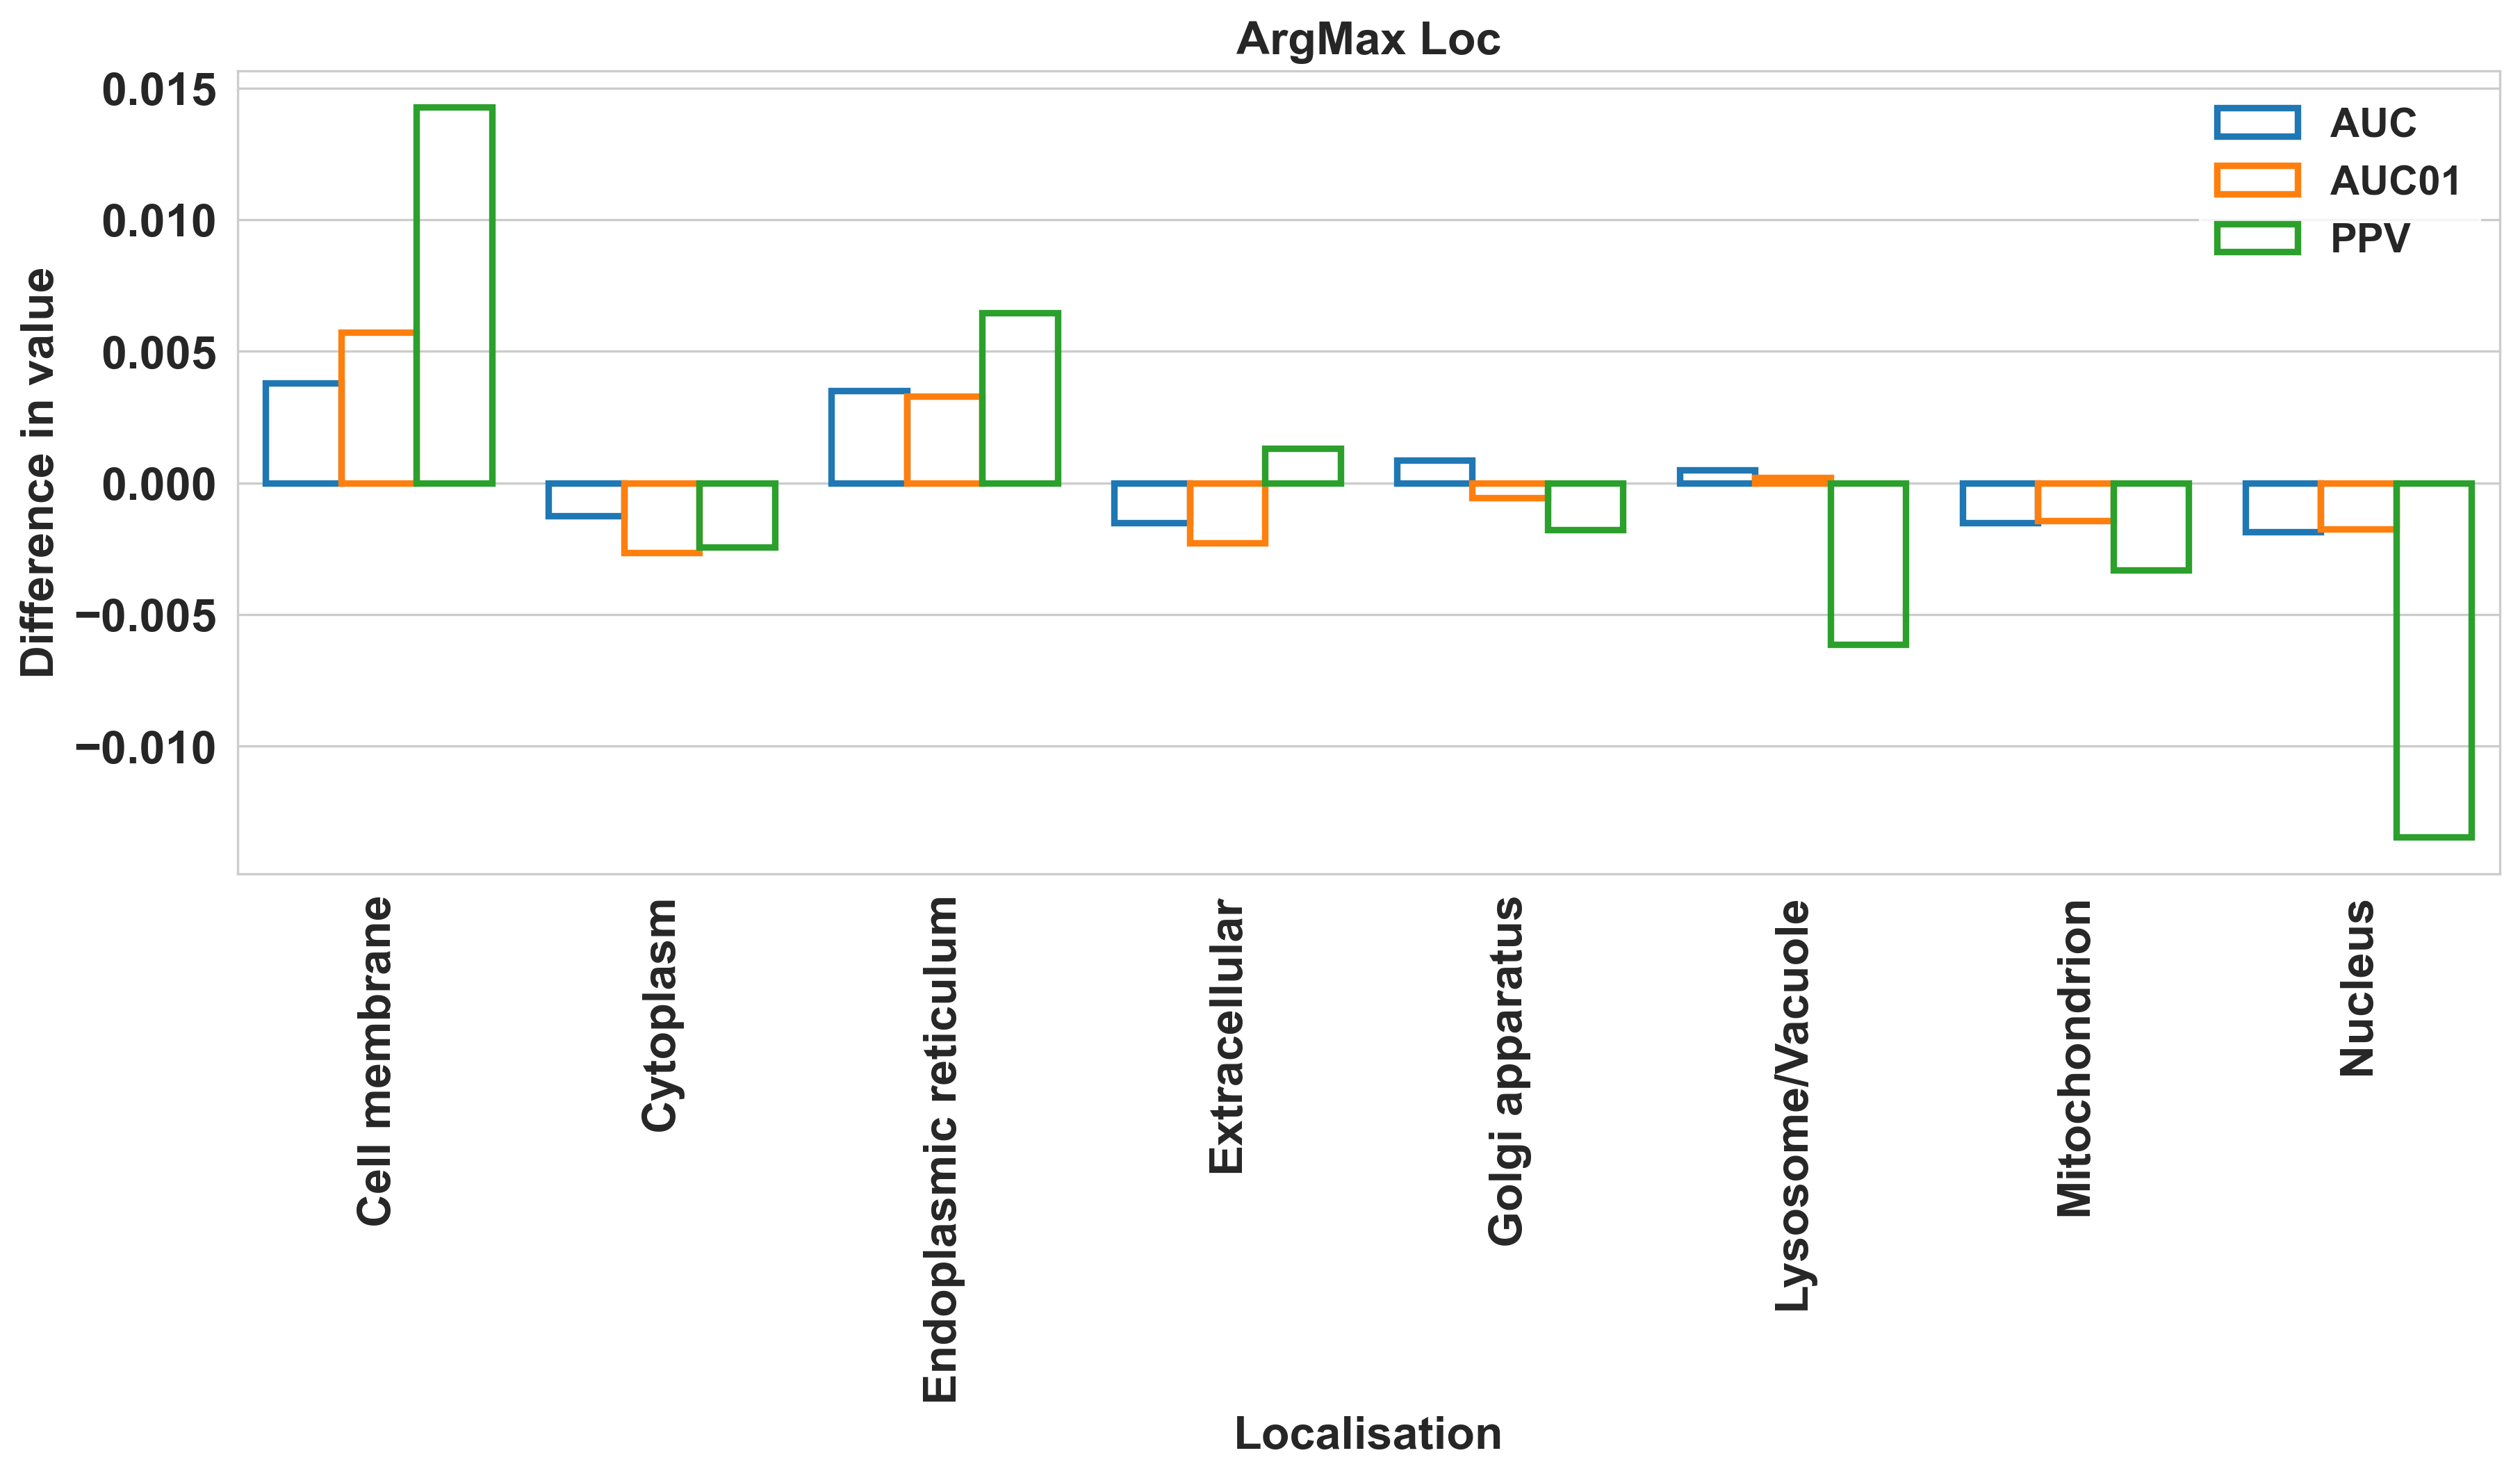

In [434]:
def make_bar(gbdf, value_cols = ['delta_AUC', 'delta_AUC01', 'delta_PPV'], filter=None,
            fs=16, fw='semibold', title=None, fn=None):
    idname=gbdf.index.name
    melted = gbdf.reset_index().melt(id_vars=[idname], value_vars=value_cols)
    if filter is not None:
        melted = melted.query(f'{idname} not in @filter')

    fig,ax = plt.subplots(1,1,figsize=(14,5))
    sns.barplot(melted.replace({'delta_AUC':'AUC',
                                'delta_AUC01':'AUC01',
                                'delta_PPV':'PPV'}),
                x=idname, y='value', hue='variable', fill=False)
    ax.set_xticklabels(ax.get_xticklabels(), fontweight=fw, fontsize=fs, rotation=90)
    ax.set_yticklabels(ax.get_yticklabels(), fontweight=fw, fontsize=fs)
    ax.set_xlabel('Localisation', fontweight=fw, fontsize=fs)
    ax.set_ylabel('Difference in value', fontweight=fw, fontsize=fs)
    ax.legend(prop={'weight':fw, 'size':fs-2},  edgecolor='w')
    if title is not None:
        ax.set_title(title, fontweight=fw, fontsize=fs)
    if fn is not None:
        fig.savefig(fn, dpi=300, bbox_inches='tight')

make_bar(c, filter=['Plastid', 'Peroxisome'], title='ArgMax Loc')

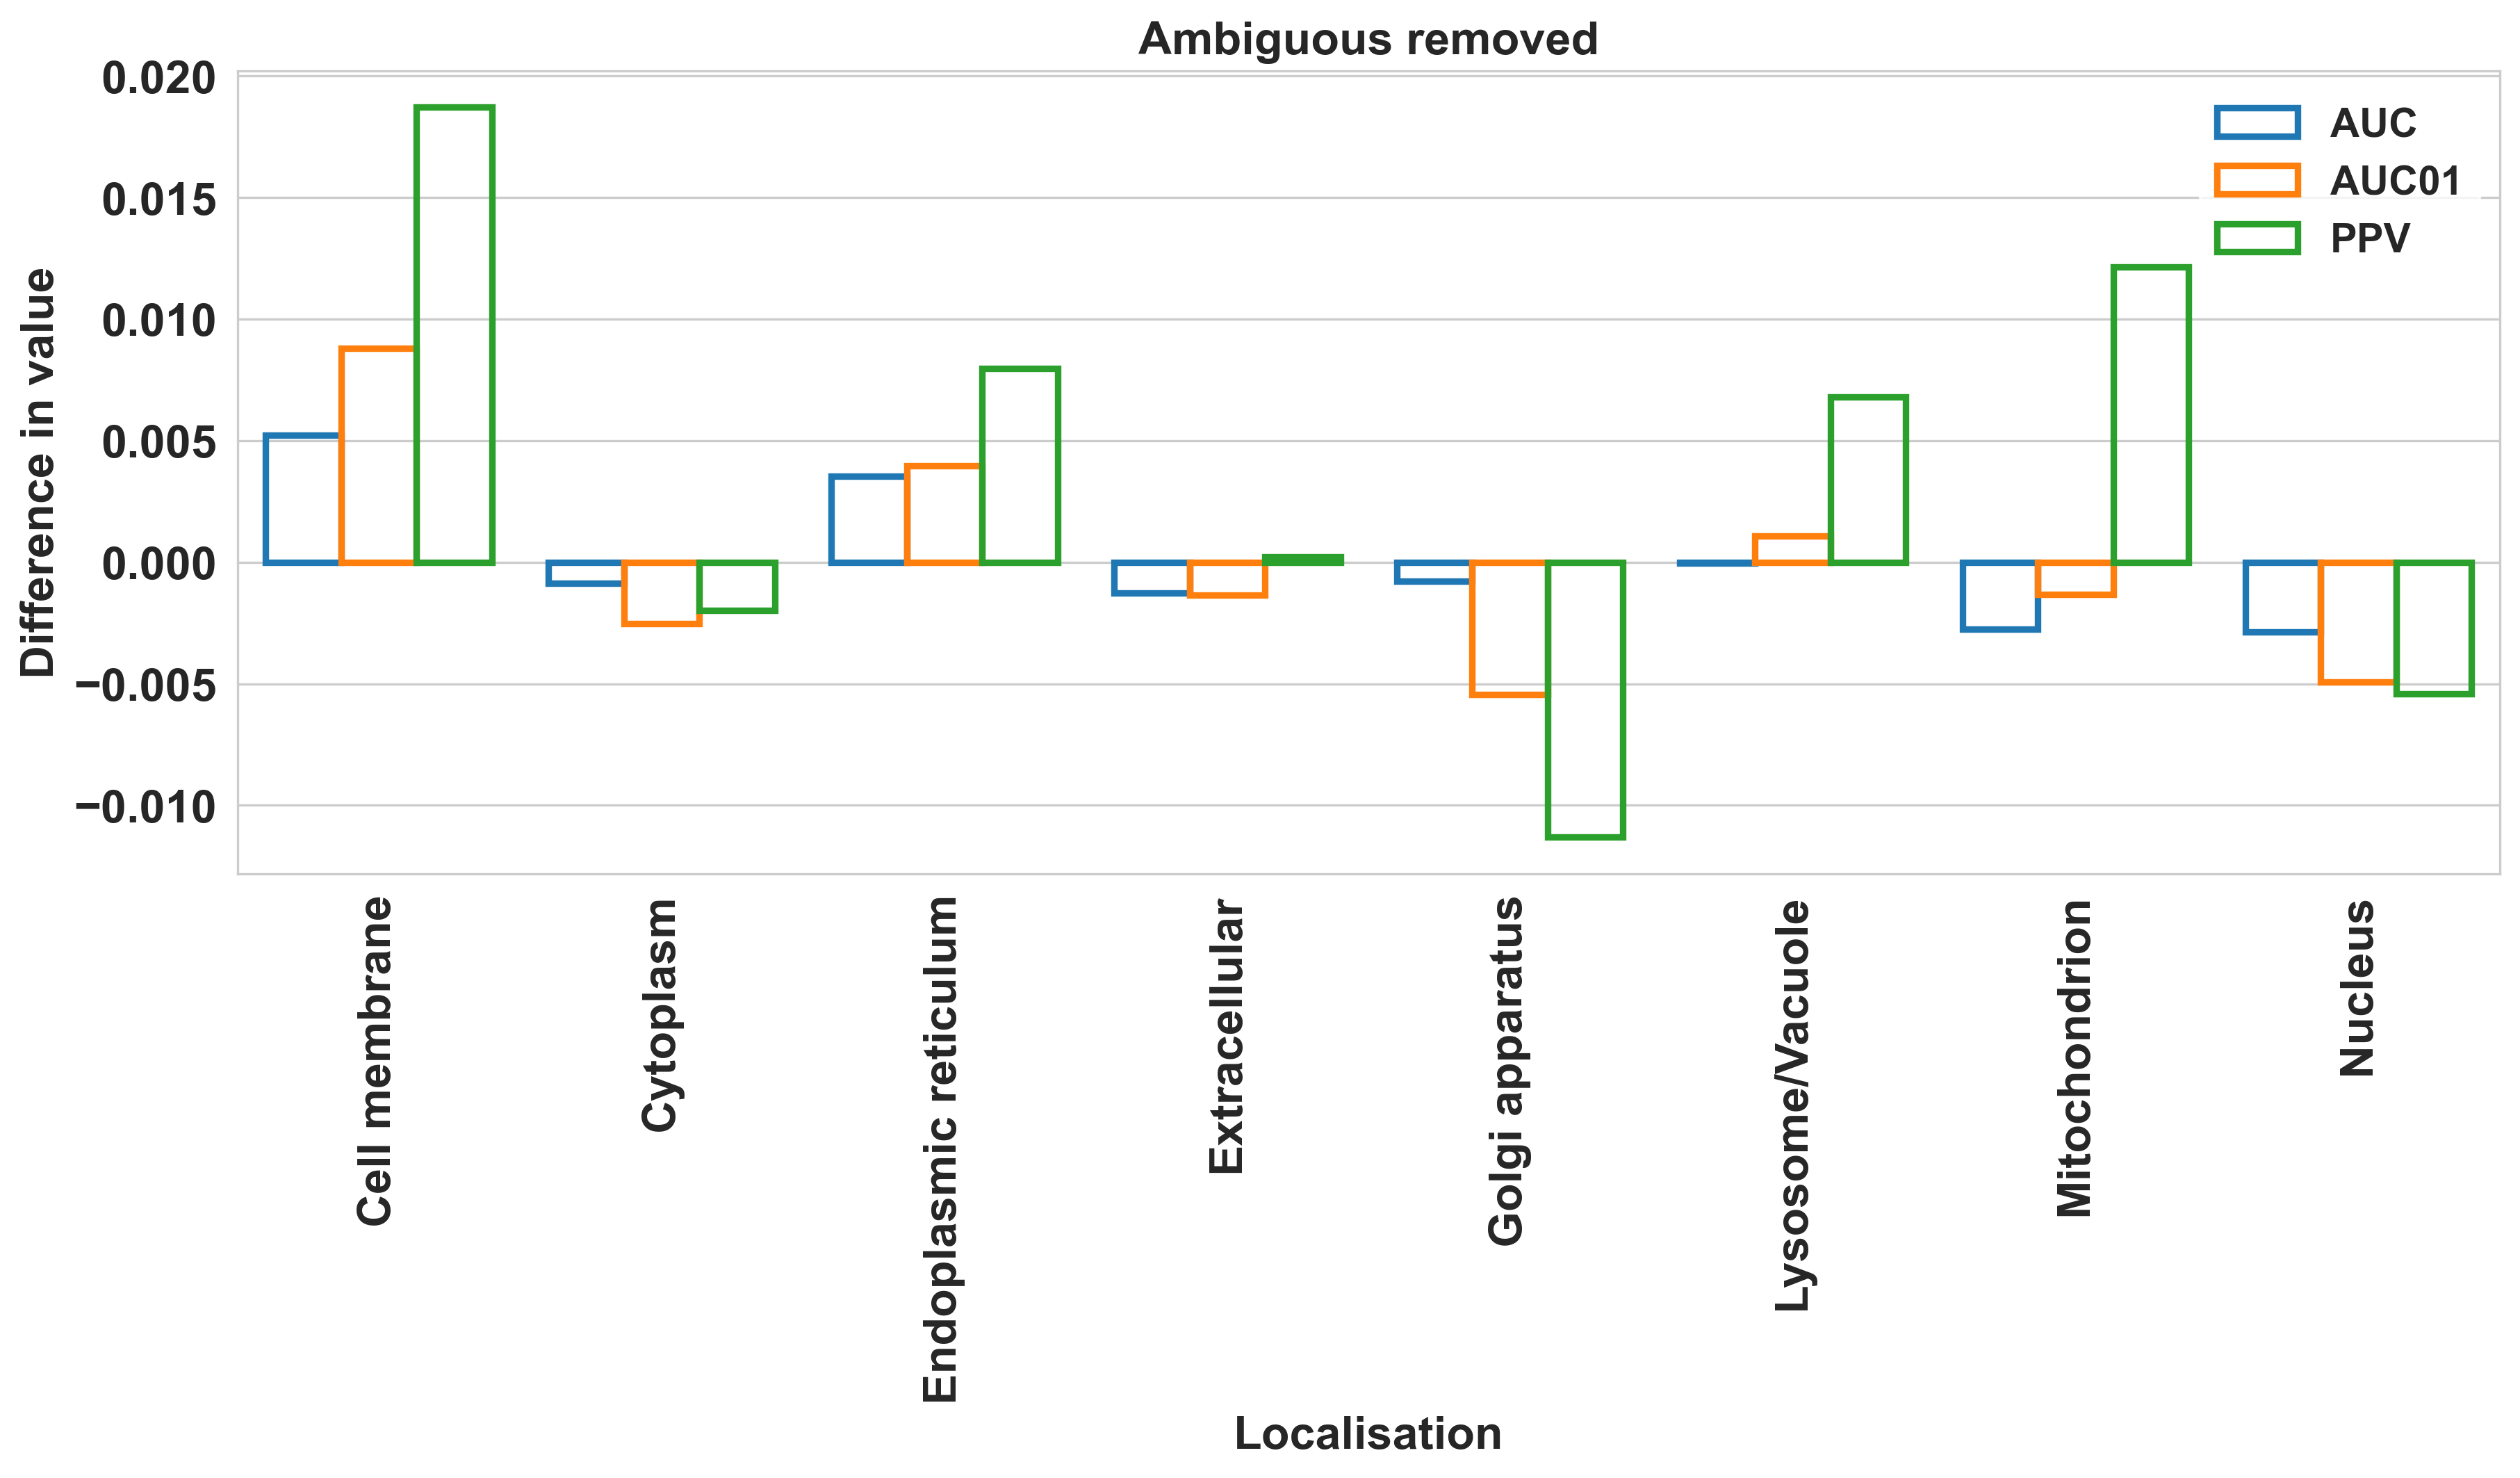

In [435]:
make_bar(a.drop([x for x in a.index if '|' in x]), filter=['Plastid', 'Peroxisome'], title='Ambiguous removed')

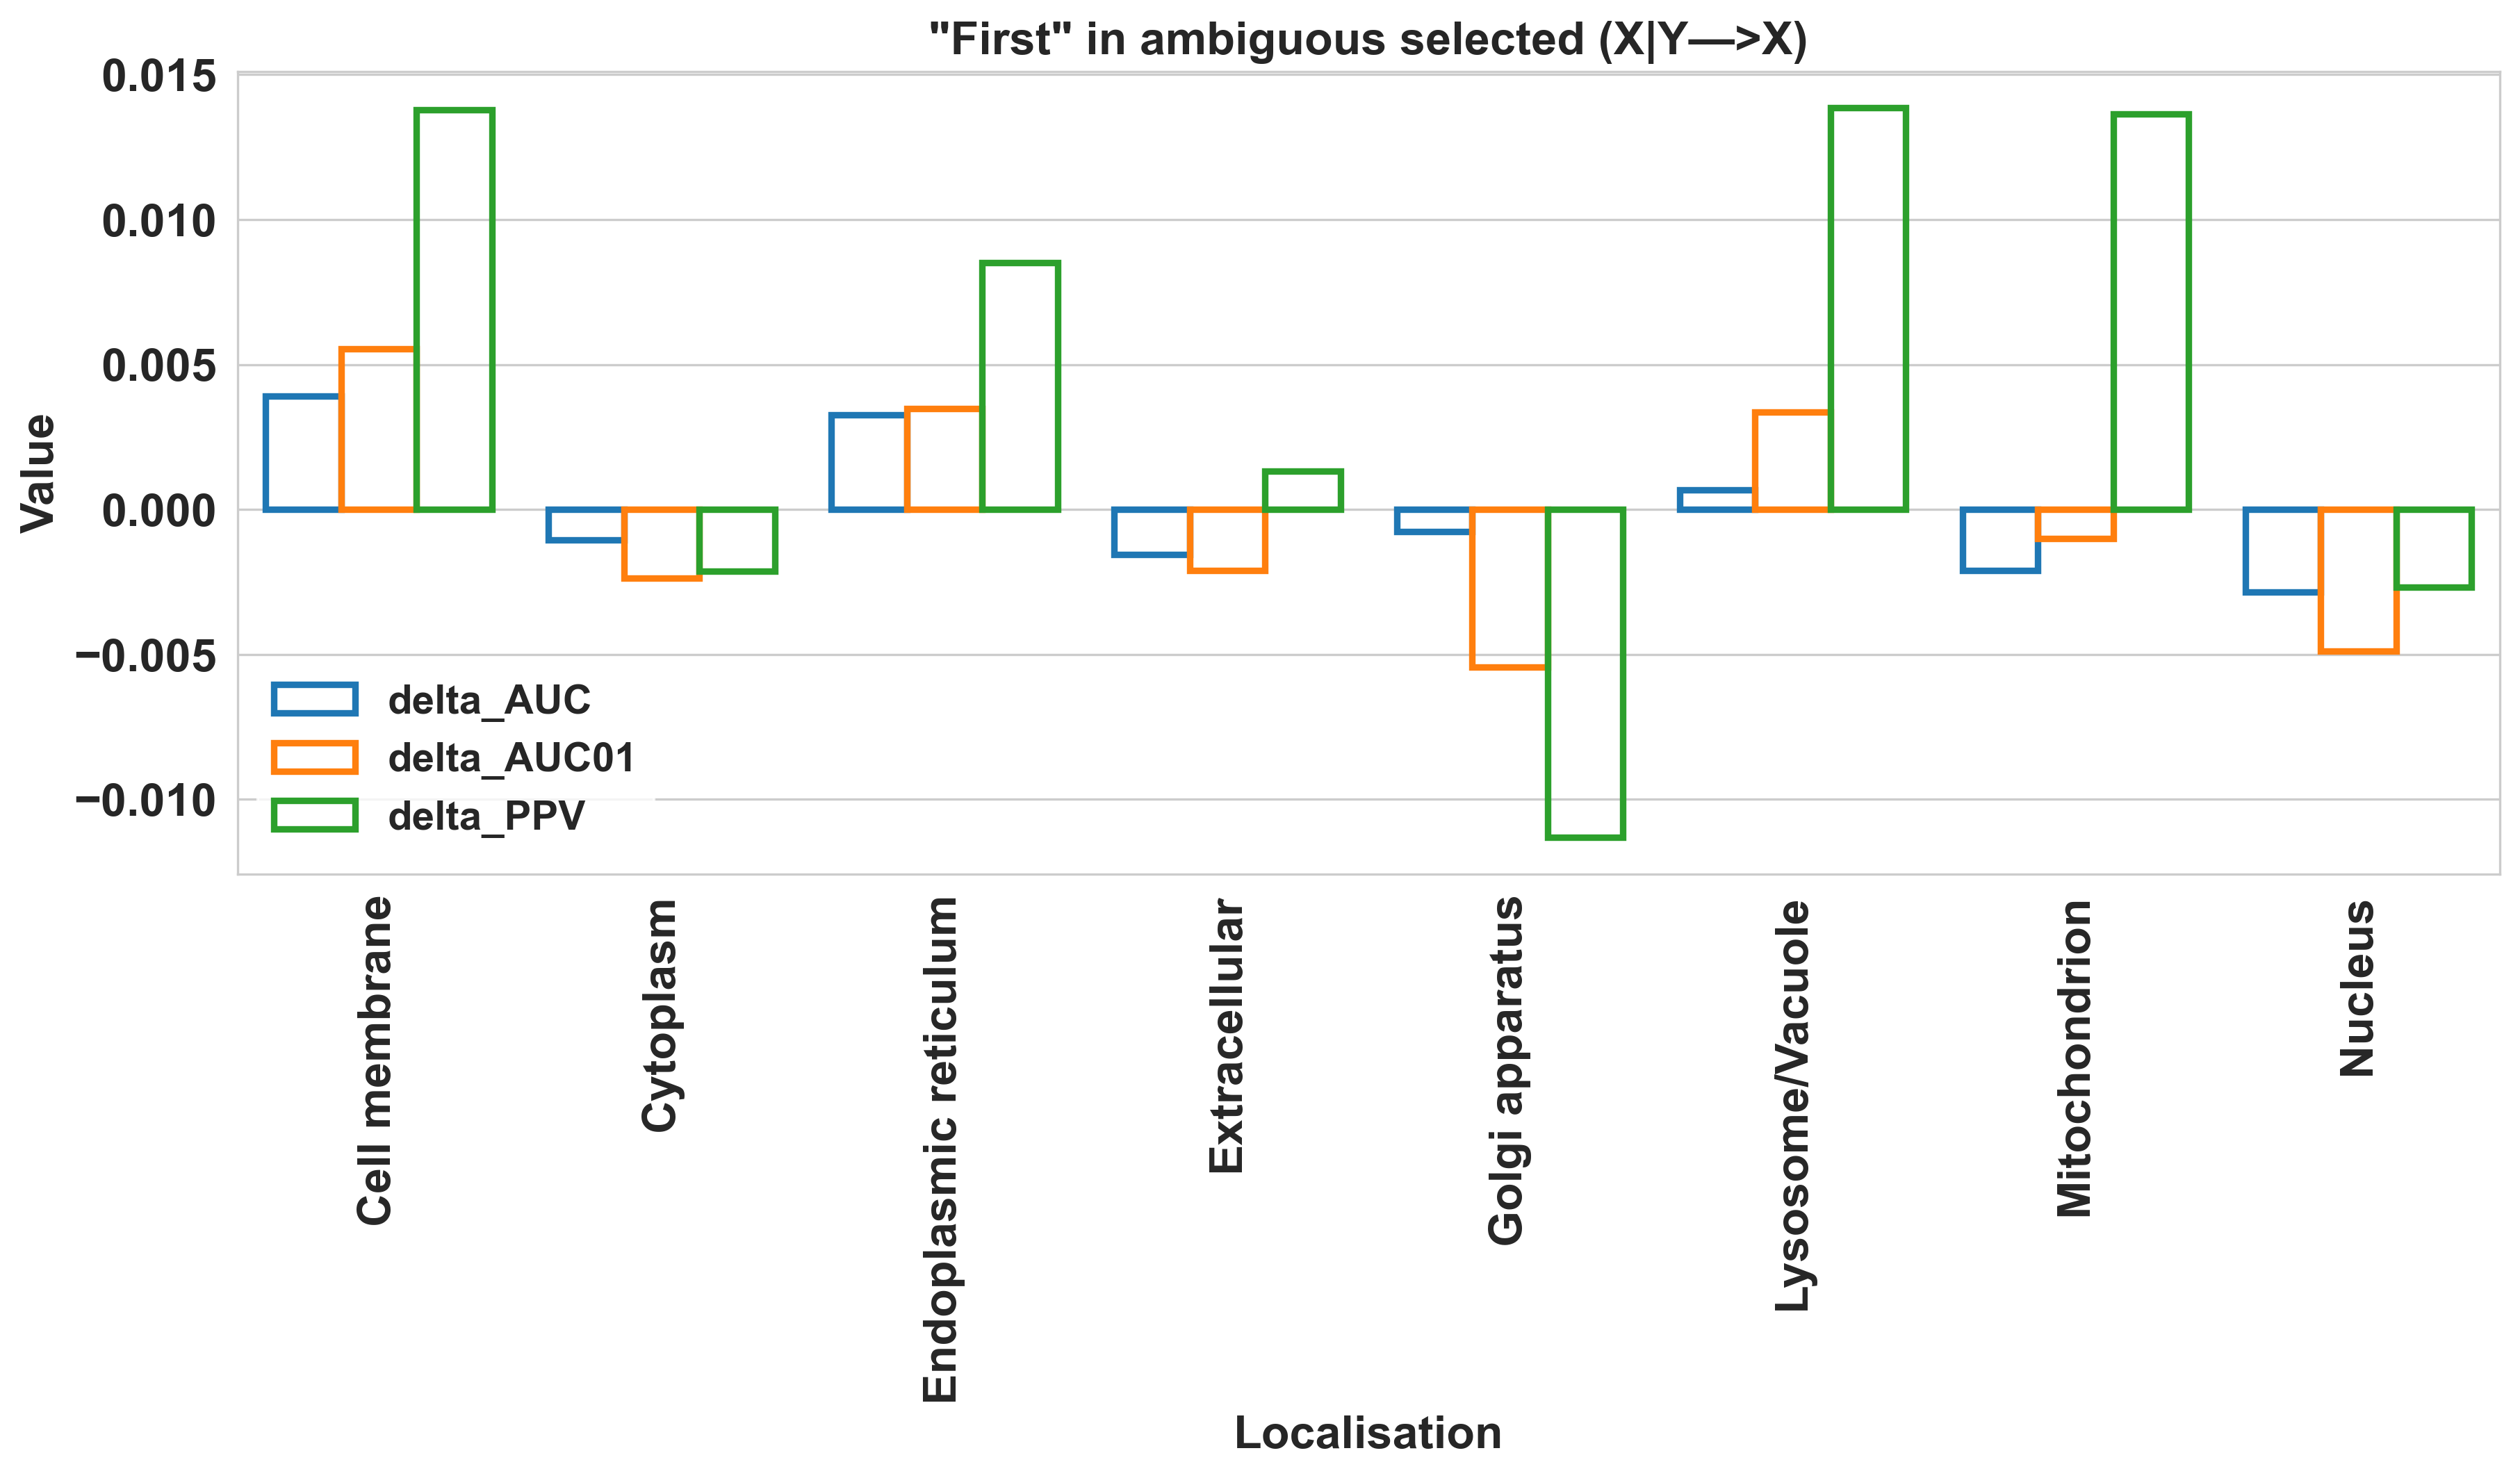

In [429]:
make_bar(b, filter=['Plastid', 'Peroxisome'], title='"First" in ambiguous selected (X|Y—>X)')

# Change struct values

In [60]:
test_2['seq_id'] = [f'SEQ_{i:07}' for i in range(len(test_2))]
re_merged=pd.merge(test_2.reset_index(), ensemble_preds_structure, how='left',
         left_on=['seq_id', 'sequence', 'MHC', 'sample', 'target', 'Prot_ID'],
         right_on=['seq_id', 'sequence', 'MHC', 'sample', 'target', 'Prot_ID'])

In [72]:
test2_top10k.columns

Index(['index', 'target', 'sequence', 'MHC', 'Unnamed: 0', 'binding_core',
       'rank_prediction', 'sample', 'mhc_reliability', 'Prot_ID',
       'prot_seq_start', 'rsa', 'pq3_H', 'pq3_E', 'pq3_C', 'disorder', 'split',
       'fold', 'mean_rsa', 'mean_disorder', 'mean_pq3_H', 'mean_pq3_E',
       'mean_pq3_C', 'seq_id', 'ensemble_pred', 'rank', 'mhc_rel'],
      dtype='object')

In [71]:
test2_top10k = re_merged.query('target==1').sort_values('ensemble_pred', ascending=False).head(10000)

In [43]:
def modify_struct(x, p=1.0):
    return ','.join([str(x) for x in (np.array([float(z) for z in x.split(',')]) * p)])

In [76]:
%mkdir ../data/NetMHCII_EL_jonas/modified_struct/
for c,p in zip(['rsa', 'pq3_H', 'pq3_E', 'pq3_C', 'disorder'],
               [1.5, 1.5, 0.5, 0.5, 1.5]):
    wtf = test2_top10k.copy()
    wtf[f'mod_{c}'] = wtf[c].apply(modify_struct, p=p)
    wtf.drop(columns=[c]).rename(columns={f'mod_{c}':c})\
                .to_csv(f'../data/NetMHCII_EL_jonas/modified_struct/250327_HLA_DR_test_top10k_modified_{c}.csv', index=False)

mkdir: ../data/NetMHCII_EL_jonas/modified_struct/: File exists


In [77]:
pd.read_csv('../data/NetMHCII_EL_jonas/modified_struct/250327_HLA_DR_test_top10k_modified_disorder.csv').columns

Index(['index', 'target', 'sequence', 'MHC', 'Unnamed: 0', 'binding_core',
       'rank_prediction', 'sample', 'mhc_reliability', 'Prot_ID',
       'prot_seq_start', 'rsa', 'pq3_H', 'pq3_E', 'pq3_C', 'split', 'fold',
       'mean_rsa', 'mean_disorder', 'mean_pq3_H', 'mean_pq3_E', 'mean_pq3_C',
       'seq_id', 'ensemble_pred', 'rank', 'mhc_rel', 'disorder'],
      dtype='object')

In [65]:
%ls ../data/NetMHCII_EL_jonas/modified_struct/

250327_HLA_DR_test_top10k_modified_disorder.csv
250327_HLA_DR_test_top10k_modified_pq3_C.csv
250327_HLA_DR_test_top10k_modified_pq3_E.csv
250327_HLA_DR_test_top10k_modified_pq3_H.csv
250327_HLA_DR_test_top10k_modified_rsa.csv
